[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ninarina12/XANESNN/blob/main/e3nn-xanes.ipynb)

# Predicting K-edge XANES with E(3)NN (Copy)

## Colab Setup

- Go to Runtime > Change runtime type, and select GPU.
- Clone the GitHub repository to access the tutorial files:

In [ ]:
!git clone https://github.com/ninarina12/XANESNN.git
%cd XANESNN

fatal: destination path 'XANESNN' already exists and is not an empty directory.
/content/XANESNN


- Install the relevant packages:

In [ ]:
!pip install numpy==1.25
#!pip uninstall torch -y
!pip install torch==2.2
!pip install ase pymatgen cmcrameri e3nn
!pip install torch-scatter torch-cluster torch-sparse torch-spline-conv -f https://pytorch-geometric.com/whl/torch-$(python -c "import torch; print(torch.__version__)").html
!pip install torch-geometric
#installing and importing the materials project infrastructure
#!pip install mp-api

Looking in links: https://pytorch-geometric.com/whl/torch-2.2.0+cu121.html


## Package imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import torch_scatter

import keras
from keras import layers
from sklearn.model_selection import train_test_split

from ase import Atom
from ase.data import atomic_masses

from tqdm import tqdm
from utils.data import XANES, Process, bar_format
from utils.e3nn import Network

#from mp_api.client import MPRester
#from emmet.core.xas import Edge, XASDoc, Type

default_dtype = torch.float64
torch.set_default_dtype(default_dtype)
#device = "cuda:0"
device = "cuda:0" if torch.cuda.is_available else "cpu"

In [ ]:
if not os.path.exists('images/'):
    os.makedirs('images/')

if not os.path.exists('models/'):
    os.makedirs('models/')

In [ ]:
print(np.__version__)

1.25.0


In [ ]:
#import json
#from scipy.signal import find_peaks

## Load and process data

In [ ]:

#Also check to see how changing to density changes like everything
#But for now just train the model with the 2300 or so smaples you have
#Good luck

In [ ]:
#Grabbing the data from the materials project
with MPRester("od4YR72wa5gNURoZWLf8w1AFriPEIagz", monty_decode=False ,use_document_model=False) as mpr:
    xas_monty = mpr.materials.xas.search(fields=['structure', 'spectrum','formula_pretty'], elements=['V'], absorbing_element='V',edge = 'K')



Retrieving XASDoc documents:   0%|          | 0/8964 [00:00<?, ?it/s]

In [ ]:
metals = ["Ti","V","Cr","Mn","Fe","Co","Ni","Cu"]

In [ ]:
# Extract only spectrum, structure, and formula
xas = {'structure': [k['spectrum']['structure'] for k in xas_monty],
       'spectrum': [k['spectrum'] for k in xas_monty],
       'formula_pretty': [k['formula_pretty'] for k in xas_monty]
      }


with open('data/V_XANES.json', 'w') as file:
    json.dump(xas, file)

In [ ]:
metals = ["Ti","V","Cr","Mn","Fe","Co","Ni","Cu"]
#use only needed fields

In [ ]:
metals = ["Ti","V","Cr","Mn","Fe","Co","Ni","Cu"]
xases = metals

for i in tqdm(range(len(metals))):
  with MPRester("od4YR72wa5gNURoZWLf8w1AFriPEIagz", monty_decode=False ,use_document_model=False) as mpr:
    xas_monty = mpr.materials.xas.search(fields=['structure', 'spectrum','formula_pretty'], elements=[metals[i]], absorbing_element=metals[i],edge = 'K')

  xases[i] = {'structure': [k['spectrum']['structure'] for k in xas_monty],
       'spectrum': [k['spectrum'] for k in xas_monty],
       'formula_pretty': [k['formula_pretty'] for k in xas_monty]
      }

  0%|          | 0/8 [00:00<?, ?it/s]

Retrieving XASDoc documents:   0%|          | 0/5875 [00:00<?, ?it/s]

 12%|█▎        | 1/8 [01:30<10:31, 90.21s/it]

Retrieving XASDoc documents:   0%|          | 0/8964 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [03:38<11:15, 112.64s/it]

Retrieving XASDoc documents:   0%|          | 0/5108 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [04:56<08:04, 96.82s/it] 

Retrieving XASDoc documents:   0%|          | 0/10492 [00:00<?, ?it/s]

 50%|█████     | 4/8 [07:24<07:47, 116.98s/it]

Retrieving XASDoc documents:   0%|          | 0/10525 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [09:47<06:18, 126.28s/it]

Retrieving XASDoc documents:   0%|          | 0/7201 [00:00<?, ?it/s]

 75%|███████▌  | 6/8 [11:33<03:58, 119.48s/it]

Retrieving XASDoc documents:   0%|          | 0/8060 [00:00<?, ?it/s]

 88%|████████▊ | 7/8 [13:16<01:54, 114.06s/it]

Retrieving XASDoc documents:   0%|          | 0/8335 [00:00<?, ?it/s]

100%|██████████| 8/8 [15:06<00:00, 113.33s/it]


In [ ]:
counter = 0
metals = ["Ti","V","Cr","Mn","Fe","Co","Ni","Cu"]
for i in range(len(metals)):
  for j in range(len(metals)):
    for k in range(len(xases[i]['formula_pretty'])):
      if j != i:
        if metals[j] in xases[i]['formula_pretty'][k]:
          counter += 1
          xases[i]['formula_pretty'][k] = "remove"
print(counter)

14109


In [ ]:
with open("transitional_metals.json", 'w') as file:
    json.dump(xases[0], file)

In [ ]:
metals = ["Mn","Fe","Au","Ag","Ti","Pt","Ni","Cr","Hg","Co","W","Cd","Li"]

for i in tqdm(range(len(metals))):
  with MPRester("od4YR72wa5gNURoZWLf8w1AFriPEIagz", monty_decode=False ,use_document_model=False) as mpr:
    xas_monty = mpr.materials.xas.search(elements=[metals[i]], absorbing_element=metals[i],edge = 'K')

  xas = {'structure': [k['spectrum']['structure'] for k in xas_monty],
       'spectrum': [k['spectrum'] for k in xas_monty],
       'formula_pretty': [k['formula_pretty'] for k in xas_monty]
      }
  spectrum_name = metals[i] + "_XANES.json"

  with open(spectrum_name, 'w') as file:
    json.dump(xas, file)



  0%|          | 0/13 [00:00<?, ?it/s]

Retrieving XASDoc documents:   0%|          | 0/10492 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/mp_api/client/core/client.py:833: UserWarning: Use the 'fields' argument to select only fields of interest to speed up data retrieval for large queries. Choose from: ['builder_meta', 'nsites', 'elements', 'nelements', 'composition', 'composition_reduced', 'formula_pretty', 'formula_anonymous', 'chemsys', 'volume', 'density', 'density_atomic', 'symmetry', 'spectrum_name', 'material_id', 'spectrum_id', 'last_updated', 'warnings', 'spectrum', 'task_ids', 'absorbing_element', 'spectrum_type', 'edge']
  warnings.warn(
  8%|▊         | 1/13 [04:21<52:17, 261.48s/it]

Retrieving XASDoc documents:   0%|          | 0/10525 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [09:36<53:39, 292.69s/it]

Retrieving XASDoc documents:   0%|          | 0/2300 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [10:34<30:59, 185.95s/it]

Retrieving XASDoc documents:   0%|          | 0/3772 [00:00<?, ?it/s]

 31%|███       | 4/13 [12:12<22:40, 151.21s/it]

Retrieving XASDoc documents:   0%|          | 0/5875 [00:00<?, ?it/s]

 38%|███▊      | 5/13 [15:16<21:44, 163.00s/it]

Retrieving XASDoc documents:   0%|          | 0/2142 [00:00<?, ?it/s]

 46%|████▌     | 6/13 [15:58<14:12, 121.85s/it]

Retrieving XASDoc documents:   0%|          | 0/8060 [00:00<?, ?it/s]

 54%|█████▍    | 7/13 [19:57<16:00, 160.10s/it]

Retrieving XASDoc documents:   0%|          | 0/5108 [00:00<?, ?it/s]

 62%|██████▏   | 8/13 [22:50<13:40, 164.11s/it]

Retrieving XASDoc documents:   0%|          | 0/2066 [00:00<?, ?it/s]

 69%|██████▉   | 9/13 [23:38<08:31, 127.85s/it]

Retrieving XASDoc documents:   0%|          | 0/7201 [00:00<?, ?it/s]

 77%|███████▋  | 10/13 [27:24<07:54, 158.25s/it]

Retrieving XASDoc documents:   0%|          | 0/3429 [00:00<?, ?it/s]

 85%|████████▍ | 11/13 [29:27<04:54, 147.29s/it]

Retrieving XASDoc documents:   0%|          | 0/2676 [00:00<?, ?it/s]

 92%|█████████▏| 12/13 [30:41<02:04, 124.97s/it]

Retrieving XASDoc documents:   0%|          | 0/21775 [00:00<?, ?it/s]

100%|██████████| 13/13 [44:38<00:00, 206.05s/it]


In [ ]:
# Load data
#data_file = 'data/Ni_K_XANES_averaged_simplified.json'
element = "Cr"
data_file1 = 'data/'+element + '_XANES'

#full_data_file = 'data/Ni_K_XANES_averaged_full.json'
xanes = XANES()
xanes.load_data(data_file1)
xanes.data

Number of samples: 5108


,structure,spectrum,formula_pretty
0,"[[3.40042864 5.95560293 2.60786873] Cr, [1.373...","{'x': [5990.929, 5991.392, 5991.807, 5992.172,...",Cr3Ag8(IO6)2
1,"[[3.40042864 5.95560293 2.60786873] Cr, [1.373...","{'x': [5990.929, 5991.181810388914, 5991.42136...",Cr3Ag8(IO6)2
2,"[[0.80642356 4.79241361 2.1138897 ] Cr, [1.524...","{'x': [5990.921, 5991.384, 5991.798, 5992.164,...",CrAgO4
3,"[[5.37064834 5.60631286 1.86895253] Cr, [1.374...","{'x': [5990.891, 5991.354, 5991.768, 5992.134,...",CrAg3ClO4
4,"[[2.16386139 1.29721867 9.02342 ] Cr, [0. 0....","{'x': [5991.884, 5993.112606515299, 5994.32437...",CrAgO2
...,...,...,...
5103,"[[ 3.43857121 2.08261365 12.6821351 ] Cr, [ 4...","{'x': [5992.923, 5994.297512725187, 5995.65468...",CrWN2
5104,"[[4.34753907 8.38749758 5.03346568] Rb, [ 1.44...","{'x': [5991.753, 5992.4742325767065, 5993.1804...",Rb2Cr2As2O9
5105,"[[2.44527519 1.72176923 1.48938564] Cr, [0.403...","{'x': [5991.043, 5991.295810388913, 5991.53536...",CrCuO4
5106,"[[-3.31923905 2.71218211 9.23240908] Li, [-2...","{'x': [5991.225, 5991.472510897642, 5991.70678...",Li2Cr2O7


Text(0.5, 0, 'Spectra Density')

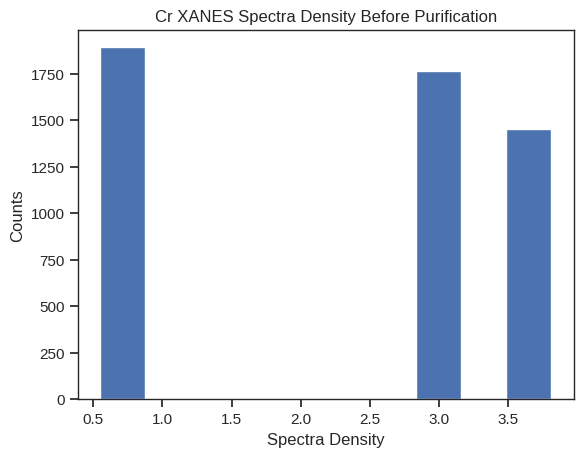

In [ ]:
#Analyzing the data before purification
densisx = np.zeros(len(xanes.data))
for i in xanes.data.index:
  densisx[i] = (max(xanes.data['spectrum'][i]['x']) - min(xanes.data['spectrum'][i]['x']))/len(xanes.data['spectrum'][i]['x'])
plt.hist(densisx)
plt.title(element + " XANES Spectra Density Before Purification")
plt.ylabel("Counts")
plt.xlabel("Spectra Density")

In [ ]:
#Removing XFAS Data (low density data)
outliers_den = []
for i in xanes.data.index:
  if (max(xanes.data['spectrum'][i]['x']) - min(xanes.data['spectrum'][i]['x']))/len(xanes.data['spectrum'][i]['x']) > 1:
    outliers_den += [xanes.data['formula_pretty'][i]]
    xanes.data = xanes.data.drop(index = i)
xanes.data.index = np.arange(0,len(xanes.data))
print(len(outliers_den))

3216


<ipython-input-45-0bfa8b34a27b>:5: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.hist(densisx,25,(0,1))


Text(0.5, 0, 'Spectra Density')

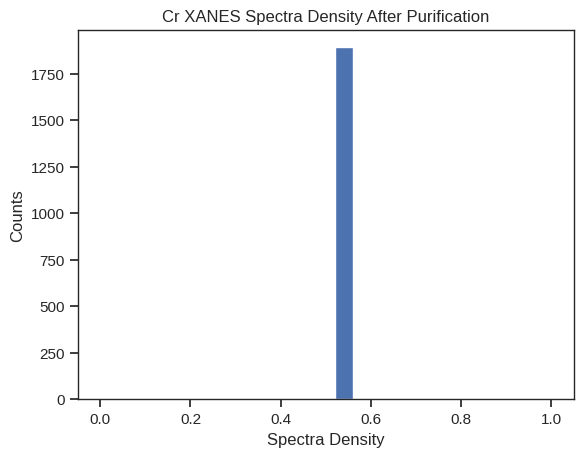

In [ ]:
#Densities after purification
densisx = np.zeros(len(xanes.data))
for i in xanes.data.index:
  densisx[i] = (max(xanes.data['spectrum'][i]['x']) - min(xanes.data['spectrum'][i]['x']))/len(xanes.data['spectrum'][i]['x'])
plt.hist(densisx,25,(0,1))
plt.title(element + " XANES Spectra Density After Purification")
plt.ylabel("Counts")
plt.xlabel("Spectra Density")

In [ ]:
#Removing repeats from the data
repeats = []
length = len(xanes.data)
for i in tqdm(xanes.data.index):
  counter = 0
  for j in range(i+1,length):
    if np.sum(xanes.data['spectrum'][i]['y']) == np.sum(xanes.data['spectrum'][j]['y']):
      if xanes.data['formula_pretty'][i] == xanes.data['formula_pretty'][j]:
        counter += 1
  if counter > 0:
    repeats += [xanes.data['formula_pretty'][i]]
    xanes.data = xanes.data.drop(index = i)
xanes.data.index = np.arange(0,len(xanes.data))
print("this data has this many repeats",len(repeats))
print("The original length of the data is", len(xanes.data))
original_length = len(xanes.data)

100%|██████████| 1892/1892 [00:40<00:00, 47.17it/s] 

this data has this many repeats 320
The original length of the data is 1572


<ipython-input-47-839cac0f3400>:9: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.hist(maxisy,13,(0,13))


(array([0.000e+00, 1.517e+03, 5.000e+01, 4.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13.]),
 <BarContainer object of 13 artists>)

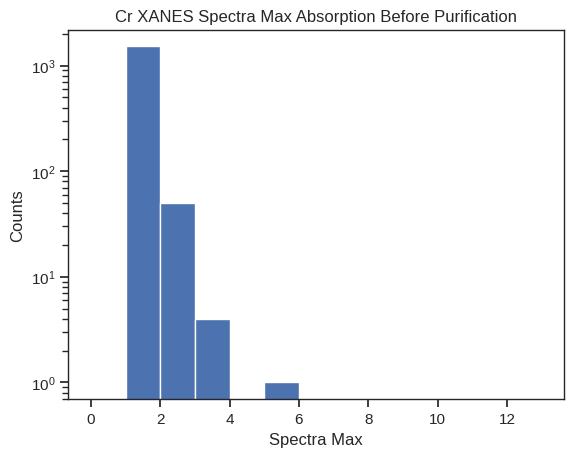

In [ ]:
#Absorbance Max before purification
maxisy = np.zeros(len(xanes.data))
for i in xanes.data.index:
  maxisy[i] = max(xanes.data['spectrum'][i]['y'])
plt.title(element + " XANES Spectra Max Absorption Before Purification")
plt.ylabel("Counts")
plt.yscale("log")
plt.xlabel("Spectra Max")
plt.hist(maxisy,13,(0,13))

(array([1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 4.000e+00, 1.564e+03]),
 array([-3.48108   , -3.12435758, -2.76763516, -2.41091274, -2.05419032,
        -1.6974679 , -1.34074548, -0.98402306, -0.62730064, -0.27057822,
         0.0861442 ]),
 <BarContainer object of 10 artists>)

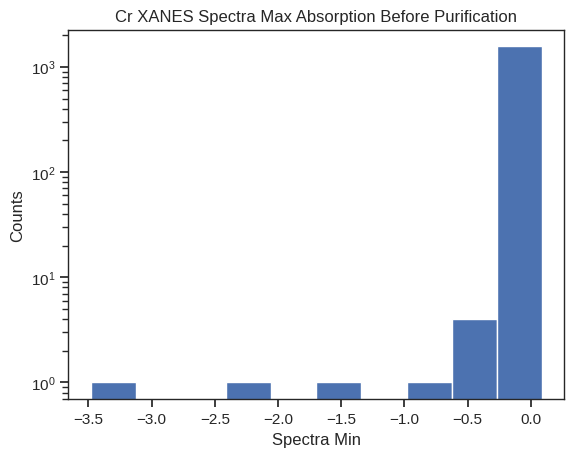

In [ ]:
#Absorbance Min before purification
minisy = np.zeros(len(xanes.data))
for i in xanes.data.index:
  minisy[i] = min(xanes.data['spectrum'][i]['y'])
plt.title(element + " XANES Spectra Max Absorption Before Purification")
plt.ylabel("Counts")
plt.yscale("log")
plt.xlabel("Spectra Min")
plt.hist(minisy)

In [ ]:
#Removing y outliers
for i in xanes.data.index:
  maxisy[i] = max(xanes.data['spectrum'][i]['y'])
for i in xanes.data.index:
  minisy[i] = min(xanes.data['spectrum'][i]['y'])

y_max_cutoff = np.mean(maxisy) + 5*np.std(maxisy)
y_min_cutoff = np.mean(minisy) - 5*np.std(minisy)
outliers_y = []
for i in xanes.data.index:
  if min(xanes.data['spectrum'][i]['y']) < y_min_cutoff or max(xanes.data['spectrum'][i]['y']) > y_max_cutoff:
    outliers_y += [xanes.data['formula_pretty'][i]]
    xanes.data = xanes.data.drop(index = i)
xanes.data.index = np.arange(0,len(xanes.data))
minisy = np.zeros(len(xanes.data))
maxisy = np.zeros(len(xanes.data))
for i in xanes.data.index:
  maxisy[i] = max(xanes.data['spectrum'][i]['y'])
for i in xanes.data.index:
  minisy[i] = min(xanes.data['spectrum'][i]['y'])
y_max_cutoff = np.mean(maxisy) + 5*np.std(maxisy)
y_min_cutoff = np.mean(minisy) - 5*np.std(minisy)
for i in xanes.data.index:
  if min(xanes.data['spectrum'][i]['y']) < y_min_cutoff or max(xanes.data['spectrum'][i]['y']) > y_max_cutoff:
    outliers_y += [xanes.data['formula_pretty'][i]]
    xanes.data = xanes.data.drop(index = i)
xanes.data.index = np.arange(0,len(xanes.data))
for i in xanes.data.index:
  maxisy[i] = max(xanes.data['spectrum'][i]['y'])
for i in xanes.data.index:
  minisy[i] = min(xanes.data['spectrum'][i]['y'])
y_max_cutoff = np.mean(maxisy) + 5*np.std(maxisy)
y_min_cutoff = np.mean(minisy) - 5*np.std(minisy)
for i in xanes.data.index:
  if min(xanes.data['spectrum'][i]['y']) < y_min_cutoff or max(xanes.data['spectrum'][i]['y']) > y_max_cutoff:
    outliers_y += [xanes.data['formula_pretty'][i]]
    xanes.data = xanes.data.drop(index = i)
xanes.data.index = np.arange(0,len(xanes.data))
for i in xanes.data.index:
  maxisy[i] = max(xanes.data['spectrum'][i]['y'])
for i in xanes.data.index:
  minisy[i] = min(xanes.data['spectrum'][i]['y'])
y_max_cutoff = np.mean(maxisy) + 5*np.std(maxisy)
y_min_cutoff = np.mean(minisy) - 5*np.std(minisy)
for i in xanes.data.index:
  if min(xanes.data['spectrum'][i]['y']) < y_min_cutoff or max(xanes.data['spectrum'][i]['y']) > y_max_cutoff:
    outliers_y += [xanes.data['formula_pretty'][i]]
    xanes.data = xanes.data.drop(index = i)
xanes.data.index = np.arange(0,len(xanes.data))
for i in xanes.data.index:
  maxisy[i] = max(xanes.data['spectrum'][i]['y'])
for i in xanes.data.index:
  minisy[i] = min(xanes.data['spectrum'][i]['y'])
y_max_cutoff = np.mean(maxisy) + 5*np.std(maxisy)
y_min_cutoff = np.mean(minisy) - 5*np.std(minisy)
for i in xanes.data.index:
  if min(xanes.data['spectrum'][i]['y']) < y_min_cutoff or max(xanes.data['spectrum'][i]['y']) > y_max_cutoff:
    outliers_y += [xanes.data['formula_pretty'][i]]
    xanes.data = xanes.data.drop(index = i)
xanes.data.index = np.arange(0,len(xanes.data))
print("this data has this many y_outliers", len(outliers_y))

this data has this many y_outliers 12


In [ ]:
print(min(minisy),max(maxisy))

-0.0477436 3.01612


(array([228., 547., 241., 224., 222.,  75.,  12.,   3.,   3.,   5.]),
 array([1.00627 , 1.194166, 1.382062, 1.569958, 1.757854, 1.94575 ,
        2.133646, 2.321542, 2.509438, 2.697334, 2.88523 ]),
 <BarContainer object of 10 artists>)

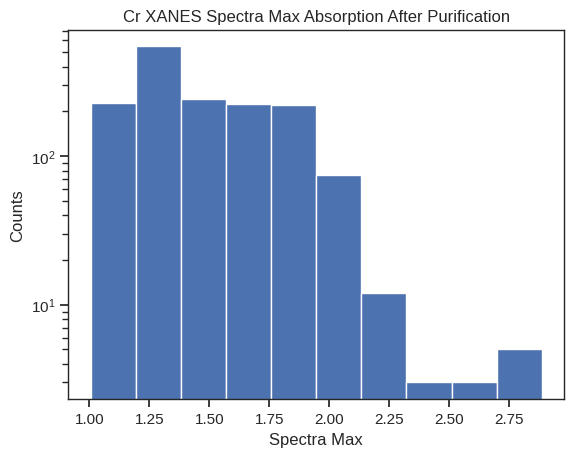

In [ ]:
#Absorbance Max after purification
maxisy = np.zeros(len(xanes.data))
for i in xanes.data.index:
  maxisy[i] = max(xanes.data['spectrum'][i]['y'])
plt.title(element + " XANES Spectra Max Absorption After Purification")
plt.ylabel("Counts")
plt.yscale("log")
plt.xlabel("Spectra Max")
plt.hist(maxisy)

(array([ 41., 759., 375., 182.,  86.,  93.,  22.,   0.,   1.,   1.]),
 array([0.00958586, 0.01724169, 0.02489753, 0.03255336, 0.0402092 ,
        0.04786503, 0.05552086, 0.0631767 , 0.07083253, 0.07848837,
        0.0861442 ]),
 <BarContainer object of 10 artists>)

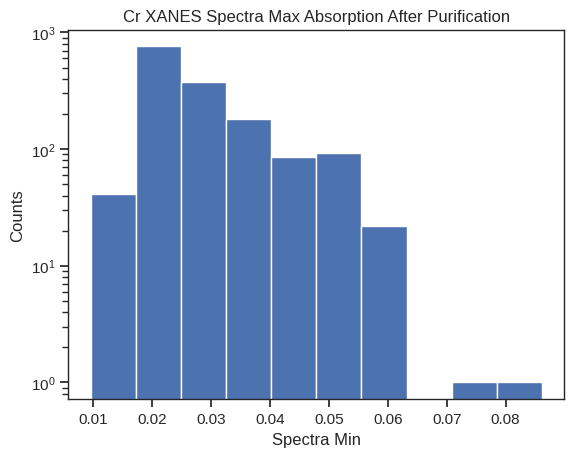

In [ ]:
#Absorbance Min after purification
minisy = np.zeros(len(xanes.data))
for i in xanes.data.index:
  minisy[i] = min(xanes.data['spectrum'][i]['y'])
plt.title(element + " XANES Spectra Max Absorption After Purification")
plt.ylabel("Counts")
plt.xlabel("Spectra Min")
plt.yscale("log")
plt.hist(minisy)

(array([   3.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1557.]),
 array([ 583.42  , 1184.7333, 1786.0466, 2387.3599, 2988.6732, 3589.9865,
        4191.2998, 4792.6131, 5393.9264, 5995.2397, 6596.553 ]),
 <BarContainer object of 10 artists>)

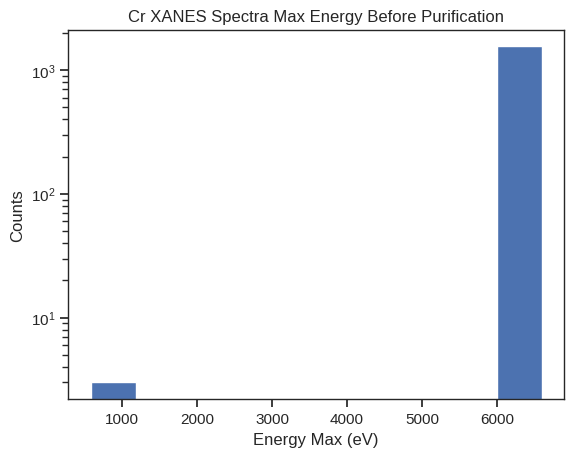

In [ ]:
#Analyzing Energy Max before purification
maxisx = np.zeros(len(xanes.data))
for i in xanes.data.index:
  maxisx[i] = max(xanes.data['spectrum'][i]['x'])
plt.title(element + " XANES Spectra Max Energy Before Purification")
plt.ylabel("Counts")
plt.yscale("log")
plt.xlabel("Energy Max (eV)")
plt.hist(maxisx)

(array([   3.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1557.]),
 array([ 528.257 , 1129.5704, 1730.8838, 2332.1972, 2933.5106, 3534.824 ,
        4136.1374, 4737.4508, 5338.7642, 5940.0776, 6541.391 ]),
 <BarContainer object of 10 artists>)

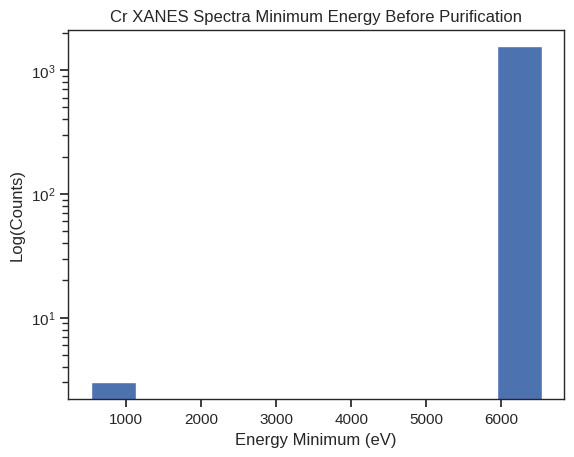

In [ ]:
#Analyzing Energy Min before purification
minisx = np.zeros(len(xanes.data))
for i in xanes.data.index:
  minisx[i] = min(xanes.data['spectrum'][i]['x'])
plt.title(element + " XANES Spectra Minimum Energy Before Purification")
plt.ylabel("Log(Counts)")
plt.yscale("log")
plt.xlabel("Energy Minimum (eV)")
plt.hist(minisx)

In [ ]:
#Removing  x outliers
for i in xanes.data.index:
  minisx[i] = min(xanes.data['spectrum'][i]['x'])
for i in xanes.data.index:
  maxisx[i] = max(xanes.data['spectrum'][i]['x'])
xmin = np.mean(minisx) + 4*np.std(minisx)
xmax = np.mean(maxisx) - 4*np.std(maxisx)
outliers_x = []
for i in xanes.data.index:
  if min(xanes.data['spectrum'][i]['x']) > xmin or max(xanes.data['spectrum'][i]['x']) < xmax:
    outliers_x += [xanes.data['formula_pretty'][i]]
    xanes.data = xanes.data.drop(index = i)
xanes.data.index = np.arange(0,len(xanes.data))
for i in xanes.data.index:
  minisx[i] = min(xanes.data['spectrum'][i]['x'])
for i in xanes.data.index:
  maxisx[i] = max(xanes.data['spectrum'][i]['x'])
xmin = np.mean(minisx) + 4*np.std(minisx)
xmax = np.mean(maxisx) - 4*np.std(maxisx)
for i in xanes.data.index:
  if min(xanes.data['spectrum'][i]['x']) > xmin or max(xanes.data['spectrum'][i]['x']) < xmax:
    outliers_x += [xanes.data['formula_pretty'][i]]
    xanes.data = xanes.data.drop(index = i)
xanes.data.index = np.arange(0,len(xanes.data))
for i in xanes.data.index:
  minisx[i] = min(xanes.data['spectrum'][i]['x'])
for i in xanes.data.index:
  maxisx[i] = max(xanes.data['spectrum'][i]['x'])
xmin = np.mean(minisx) + 4*np.std(minisx)
xmax = np.mean(maxisx) - 4*np.std(maxisx)
for i in xanes.data.index:
  if min(xanes.data['spectrum'][i]['x']) > xmin or max(xanes.data['spectrum'][i]['x']) < xmax:
    outliers_x += [xanes.data['formula_pretty'][i]]
    xanes.data = xanes.data.drop(index = i)
xanes.data.index = np.arange(0,len(xanes.data))
for i in xanes.data.index:
  minisx[i] = min(xanes.data['spectrum'][i]['x'])
for i in xanes.data.index:
  maxisx[i] = max(xanes.data['spectrum'][i]['x'])
xmin = np.mean(minisx) + 4*np.std(minisx)
xmax = np.mean(maxisx) - 4*np.std(maxisx)
for i in xanes.data.index:
  if min(xanes.data['spectrum'][i]['x']) > xmin or max(xanes.data['spectrum'][i]['x']) < xmax:
    outliers_x += [xanes.data['formula_pretty'][i]]
    xanes.data = xanes.data.drop(index = i)
xanes.data.index = np.arange(0,len(xanes.data))
for i in xanes.data.index:
  minisx[i] = min(xanes.data['spectrum'][i]['x'])
for i in xanes.data.index:
  maxisx[i] = max(xanes.data['spectrum'][i]['x'])
xmin = np.mean(minisx) + 4*np.std(minisx)
xmax = np.mean(maxisx) - 4*np.std(maxisx)
for i in xanes.data.index:
  if min(xanes.data['spectrum'][i]['x']) > xmin or max(xanes.data['spectrum'][i]['x']) < xmax:
    outliers_x += [xanes.data['formula_pretty'][i]]
    xanes.data = xanes.data.drop(index = i)
xanes.data.index = np.arange(0,len(xanes.data))
for i in xanes.data.index:
  minisx[i] = min(xanes.data['spectrum'][i]['x'])
for i in xanes.data.index:
  maxisx[i] = max(xanes.data['spectrum'][i]['x'])
xmin = max(minisx)
xmax = min(maxisx)
print("This data has this many x outliers", len(outliers_x))
print(xmin,xmax)

This data has this many x outliers 32
5996.172 6045.686


(array([499., 350., 206., 244., 121.,  32.,  23.,  18.,  16.,  19.]),
 array([6045.686 , 6046.2509, 6046.8158, 6047.3807, 6047.9456, 6048.5105,
        6049.0754, 6049.6403, 6050.2052, 6050.7701, 6051.335 ]),
 <BarContainer object of 10 artists>)

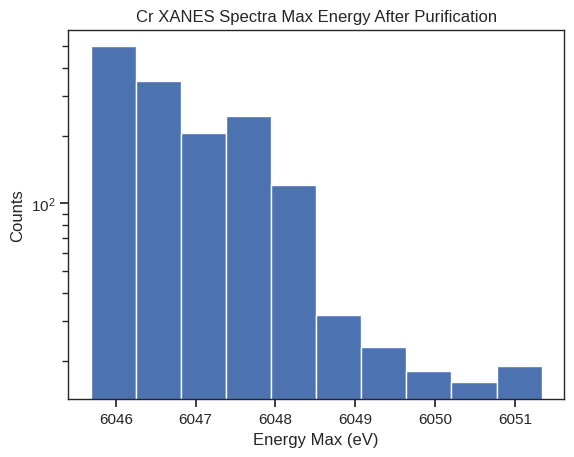

In [ ]:
#Analyzing Energy Max after purification
maxisx = np.zeros(len(xanes.data))
for i in xanes.data.index:
  maxisx[i] = max(xanes.data['spectrum'][i]['x'])
plt.title(element + " XANES Spectra Max Energy After Purification")
plt.ylabel("Counts")
plt.yscale("log")
plt.xlabel("Energy Max (eV)")
plt.hist(maxisx)

(array([499., 350., 206., 244., 121.,  32.,  23.,  18.,  16.,  19.]),
 array([5990.523 , 5991.0879, 5991.6528, 5992.2177, 5992.7826, 5993.3475,
        5993.9124, 5994.4773, 5995.0422, 5995.6071, 5996.172 ]),
 <BarContainer object of 10 artists>)

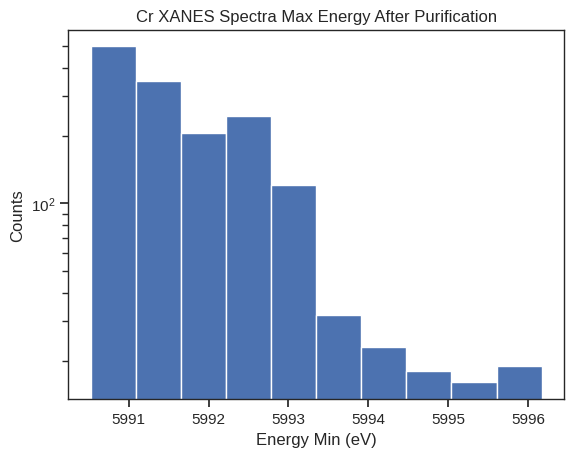

In [ ]:
#Analyzing Energy Min after purification
minisx = np.zeros(len(xanes.data))
for i in xanes.data.index:
  minisx[i] = min(xanes.data['spectrum'][i]['x'])
plt.title(element + " XANES Spectra Max Energy After Purification")
plt.ylabel("Counts")
plt.yscale("log")
plt.xlabel("Energy Min (eV)")
plt.hist(minisx)

In [ ]:
#Check to see if any radioactive stuff is contained
radio = ('Bi','Po','At','Rn',
              'Fr','Ra','Ac','Th','Pa','U','Np','Pu','Am','Cm','Bk','Cf','Es','Fm')
for i in xanes.data.index:
  for j in radio:
    if j in xanes.data['formula_pretty'][i]:
      print(j,i,xanes.data['formula_pretty'][i])

U 1 Ba2UFeO6
Bi 36 FeBiO3
U 97 U(FeGe)2
U 192 U(FeSi)2
Th 224 Th(Al5Fe)2
Np 236 Np(FeGe)2
Np 243 Np(FeSi)2
Np 249 NpFe2
U 311 UFe3B2
U 376 U(FeP3)4
Th 403 ThFe2SiC
Th 470 ThFe5
Bi 539 MnFeBiO5
Th 586 Th(FeGe)2
U 746 UFeS3
U 797 U6Fe16Si7
Bi 957 Li2Fe3BiO8
Bi 1052 MgFeBiO5
U 1076 U2Al20Fe
Bi 1134 FeBiO3
Th 1298 Th(FeP3)4
U 1336 Sr2UFeO6
Th 1633 Th(Fe2P)2
Bi 1693 Ho6FeBi2
Bi 1744 CaFeBiO5
Bi 1807 Zn3Fe4(BiO4)6
Bi 1898 FeBiO3
U 1912 UFeO4
U 1916 UFeC2
Bi 1941 FeBiO3
Bi 1965 TiFe(BiO3)2
Bi 2054 Li4FeBi(TeO6)2
Bi 2151 FeBiO3
U 2169 U6Fe16Si7C
Bi 2173 Sr15Fe10(Bi5O23)2
Bi 2174 CrFe(BiO3)2
Bi 2220 FeBiSbS4
Th 2335 Th5Fe19P12
Bi 2336 FeBi3(MoO6)2
U 2341 UFe2
U 2360 U2Fe2Sn
U 2364 U2FeS5
U 2379 U(Al5Fe)2
Bi 2385 CaFeBiO5
Pa 2418 PaFe3
Np 2494 NpFe3
Bi 2604 CaLaFeBiO6
U 2737 U2Fe3Ge
U 2746 U2Fe12P7
U 2779 UFeSi
Th 2783 Th7Fe3
Bi 2792 Mg3Fe4(BiO4)6
Bi 2835 Ce21Fe8Bi7C12
Bi 2909 MgFeBiO5
Bi 2916 Fe4Bi2O9
U 2918 U4Ga12Fe
Pu 2920 Pu(FeSi)2
Bi 2935 LaFeBiO6
Th 2972 ThFe5P3
Bi 2993 FeBiO3
Bi 3002 Ga2F

In [ ]:
#Removing outlier elements from our dataset
#Only those with less than 10 examples each
#We run through the data multiple time though because sometimes removing data can
#move an element to the outlier range so we must go through it again
elements = ('H','He','Li','Be','B','C','N','O','F','Ne','Na','Mg','Al','Si','P','S','Cl','Ar','K','Ca','Sc','Ti',
              'V','Cr','Mn','Fe','Co','Ni','Cu','Zn','Ga','Ge','As','Se','Br','Kr','Rb','Sr','Y','Zr','Nb','Mo','Tc','Ru',
              'Rh','Pd','Ag','Cd','In','Sn','Sb','Te','I','Xe','Cs','Ba','La','Ce','Pr','Nd','Pm','Sm','Eu','Gd','Tb',
              'Dy','Ho','Er','Tm','Yb','Lu','Hf','Ta','W','Re','Os','Ir','Pt','Au','Hg','Tl','Pb','Bi','Po','At','Rn',
              'Fr','Ra','Ac','Th','Pa','U','Np','Pu','Am','Cm','Bk','Cf','Es','Fm')
outliers_e = []
not_included_elements = []
afters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789()'
for t in range(5):
  for e in elements:
    elemental_counter = 0
    for i in xanes.data.index:
      if e in xanes.data['formula_pretty'][i]:
        if len(e) > 1:
          elemental_counter += 1
        else:
            for u in afters:
              if xanes.data['formula_pretty'][i][len(xanes.data['formula_pretty'][i])-1] == e:
                elemental_counter += 1
                break
              if e + u in xanes.data['formula_pretty'][i]:
                elemental_counter += 1
                break
    if elemental_counter < 10:
      if t==4:
        not_included_elements += [e]
      for i in xanes.data.index:
        if e in xanes.data['formula_pretty'][i]:
          if len(e) > 1:
            outliers_e += [xanes.data['formula_pretty'][i]]
            xanes.data = xanes.data.drop(index = i)
          else:
            for u in afters:
              if xanes.data['formula_pretty'][i][len(xanes.data['formula_pretty'][i])-1] == e:
                outliers_e += [xanes.data['formula_pretty'][i]]
                xanes.data = xanes.data.drop(index = i)
                break
              if e + u in xanes.data['formula_pretty'][i]:
                outliers_e += [xanes.data['formula_pretty'][i]]
                xanes.data = xanes.data.drop(index = i)
                break
xanes.data.index = np.arange(0,len(xanes.data))
print("The number of elemental outliers is", len(outliers_e))
print("The list of not included elements is", not_included_elements)
print("the number of missing element is", len(not_included_elements))
print(len(xanes.data))

The number of elemental outliers is 151
The list of not included elements is ['He', 'Be', 'Ne', 'Ar', 'Sc', 'Se', 'Br', 'Kr', 'Zr', 'Mo', 'Tc', 'Ru', 'Rh', 'Pd', 'Cd', 'In', 'Xe', 'Ce', 'Pr', 'Nd', 'Pm', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy', 'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Re', 'Os', 'Ir', 'Pt', 'Au', 'Pb', 'Po', 'At', 'Rn', 'Fr', 'Ra', 'Ac', 'Th', 'Pa', 'Np', 'Pu', 'Am', 'Cm', 'Bk', 'Cf', 'Es', 'Fm']
the number of missing element is 54
1377


(array([  8.,  18.,  31.,  52.,  59.,  84., 128., 124.,  76.,  71.,  61.,
         49.,  42.,  24.,  40.,  37.,  40.,  40.,  34.,  50.,  35.,  59.,
         39.,  34.,  38.,  50.,  13.,   7.,   6.,   5.,   4.,   3.,   3.,
          3.,   2.,   0.,   1.,   0.,   2.,   0.,   0.,   0.,   2.,   0.,
          1.,   0.,   0.,   0.,   1.,   1.]),
 array([1.01655  , 1.0534392, 1.0903284, 1.1272176, 1.1641068, 1.200996 ,
        1.2378852, 1.2747744, 1.3116636, 1.3485528, 1.385442 , 1.4223312,
        1.4592204, 1.4961096, 1.5329988, 1.569888 , 1.6067772, 1.6436664,
        1.6805556, 1.7174448, 1.754334 , 1.7912232, 1.8281124, 1.8650016,
        1.9018908, 1.93878  , 1.9756692, 2.0125584, 2.0494476, 2.0863368,
        2.123226 , 2.1601152, 2.1970044, 2.2338936, 2.2707828, 2.307672 ,
        2.3445612, 2.3814504, 2.4183396, 2.4552288, 2.492118 , 2.5290072,
        2.5658964, 2.6027856, 2.6396748, 2.676564 , 2.7134532, 2.7503424,
        2.7872316, 2.8241208, 2.86101  ]),
 <BarContainer object o

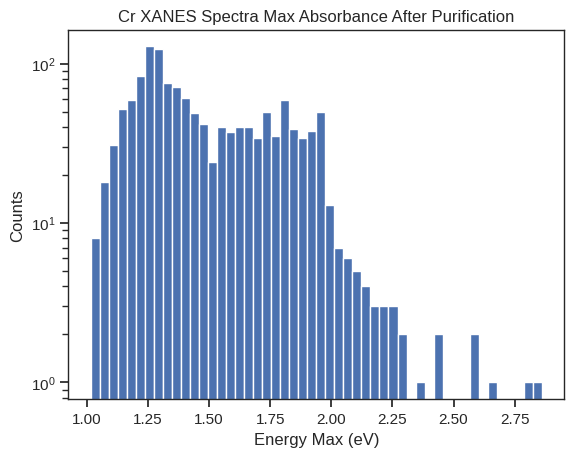

In [ ]:
#Analyzing Max Absorbance After purification
maxisy = np.zeros(len(xanes.data))
for i in xanes.data.index:
  maxisy[i] = max(xanes.data['spectrum'][i]['y'])
plt.title(element + " XANES Spectra Max Absorbance After Purification")
plt.ylabel("Counts")
plt.yscale("log")
plt.xlabel("Energy Max (eV)")
plt.hist(maxisy,50)

(array([ 38., 722., 318., 130.,  73.,  80.,  14.,   0.,   1.,   1.]),
 array([0.00958586, 0.01724169, 0.02489753, 0.03255336, 0.0402092 ,
        0.04786503, 0.05552086, 0.0631767 , 0.07083253, 0.07848837,
        0.0861442 ]),
 <BarContainer object of 10 artists>)

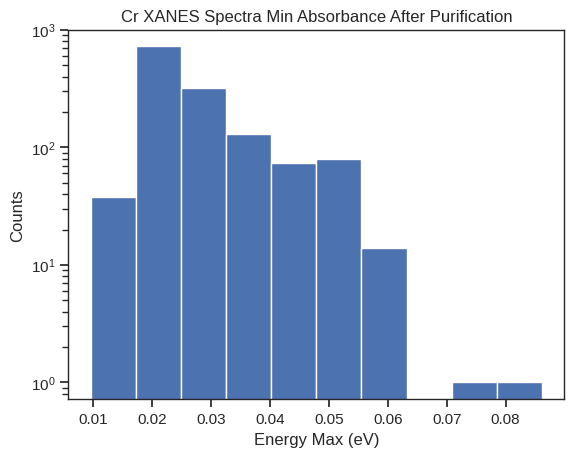

In [ ]:
#Analyzing Min Absorbance After purification
minisy = np.zeros(len(xanes.data))
for i in xanes.data.index:
  minisy[i] = min(xanes.data['spectrum'][i]['y'])
plt.title(element + " XANES Spectra Min Absorbance After Purification")
plt.ylabel("Counts")
plt.yscale("log")
plt.xlabel("Energy Max (eV)")
plt.hist(minisy)

In [ ]:
#Getting the data kept percentage
print("we kept this percent of the original data", 100*len(xanes.data)/original_length)

we kept this percent of the original data 87.59541984732824


Mn6O11F


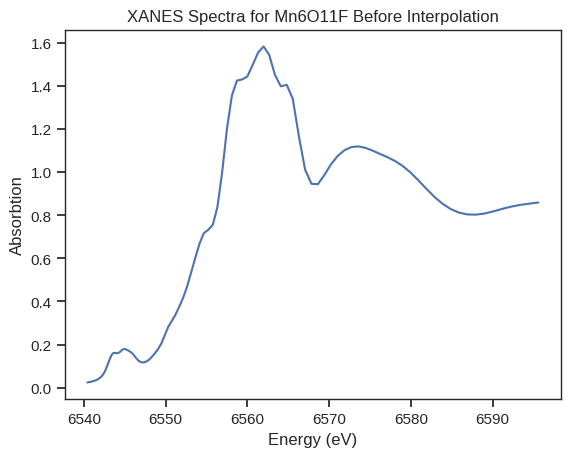

In [ ]:
gob = 414
plt.plot(xanes.data['spectrum'][gob]['x'],xanes.data['spectrum'][gob]['y'])
plt.title("XANES Spectra for " + xanes.data['formula_pretty'][gob] + " Before Interpolation")
plt.ylabel("Absorbtion")
plt.xlabel("Energy (eV)")
print(xanes.data['formula_pretty'][gob])

In [ ]:
# TO DO: Interpolate XANES data to uniform energy bins
x_new = np.linspace(xmin,xmax,len(xanes.data['spectrum'][0]['y']))
MSE = 0
for i in xanes.data.index:
  x_old = xanes.data['spectrum'][i]['x']
  y_old = xanes.data['spectrum'][i]['y']
  y_new = np.interp(x_new,x_old,y_old)
  xanes.data['spectrum'][i]['x'] = x_new
  xanes.data['spectrum'][i]['y'] = y_new
  y_pred = np.interp(x_old,x_new,y_new)
  MSE += np.mean((y_old-y_pred)**2)
MSE = MSE/len(xanes.data)
#plt.plot(x_old,y_old)
#plt.plot(x_new,y_new)
print(MSE)

0.007570817764940236


Mn6O11F


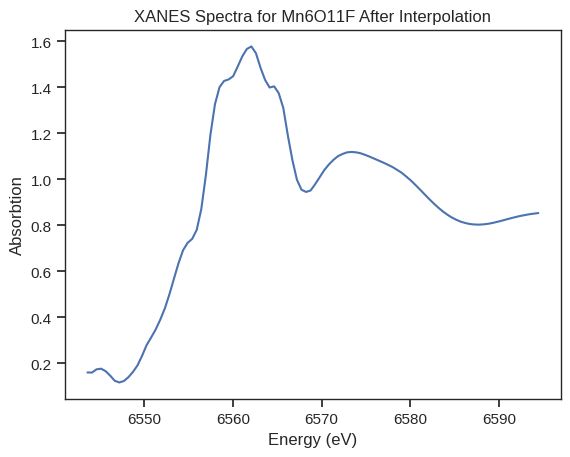

In [ ]:
plt.plot(xanes.data['spectrum'][gob]['x'],xanes.data['spectrum'][gob]['y'])
plt.title("XANES Spectra for " + xanes.data['formula_pretty'][gob] + " After Interpolation")
plt.ylabel("Absorbtion")
plt.xlabel("Energy (eV)")
print(xanes.data['formula_pretty'][gob])

In [ ]:
#Change the y values into peak locations
max_peaks = 0
for i in xa#nes.data.index:
  x_peaks = find_peaks(xanes.data['spectrum'][i]['y'])[0]
  if len(x_peaks) > max_peaks:
    max_peaks = len(x_peaks)
for i in xanes.data.index:
  x_peaks = find_peaks(xanes.data['spectrum'][i]['y'])[0]
  #print(len(x_peaks))
  #y = np.ones(6)*-1
  y_new = np.pad(x_peaks, (0, max_peaks-len(x_peaks)), 'constant',constant_values=(0, -50))/100
  xanes.data['spectrum'][i]['y'] = y_new

SyntaxError: expected ':' (<ipython-input-31-7fdc90d0b9f3>, line 3)

VCoB3
V3(O2F)2


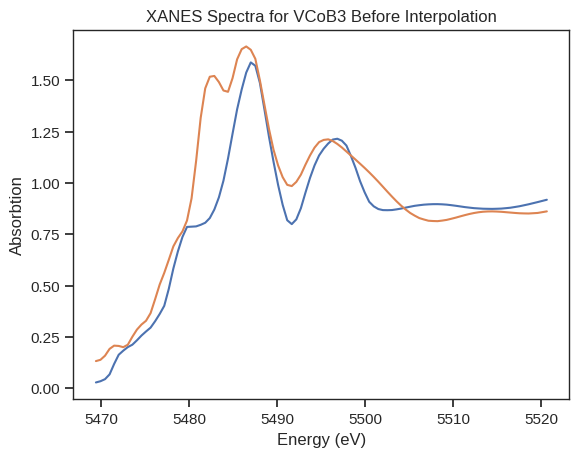

In [ ]:
gob = 414
geb = 162
plt.plot(xanes.data['spectrum'][gob]['x'],xanes.data['spectrum'][gob]['y'])
plt.title("XANES Spectra for " + xanes.data['formula_pretty'][gob] + " Before Interpolation")
plt.ylabel("Absorbtion")
plt.xlabel("Energy (eV)")
plt.plot(xanes.data['spectrum'][geb]['x'],xanes.data['spectrum'][geb]['y'])
print(xanes.data['formula_pretty'][gob])
print(xanes.data['formula_pretty'][geb])

In [ ]:
#Designing the function that can turn formulas into vectors
def element_to_vector(element):
  #Only using the first 100 elements since none past that point are in the sample data
  elements = ('H','He','Li','Be','B','C','N','O','F','Ne','Na','Mg','Al','Si','P','S','Cl','Ar','K','Ca','Sc','Ti',
              'V','Cr','Mn','Fe','Co','Ni','Cu','Zn','Ga','Ge','As','Se','Br','Kr','Rb','Sr','Y','Zr','Nb','Mo','Tc','Ru',
              'Rh','Pd','Ag','Cd','In','Sn','Sb','Te','I','Xe','Cs','Ba','La','Ce','Pr','Nd','Pm','Sm','Eu','Gd','Tb',
              'Dy','Ho','Er','Tm','Yb','Lu','Hf','Ta','W','Re','Os','Ir','Pt','Au','Hg','Tl','Pb','Bi','Po','At','Rn',
              'Fr','Ra','Ac','Th','Pa','U','Np','Pu','Am','Cm','Bk','Cf','Es','Fm')
  vector = np.zeros(len(elements))
  counter = 0
  for i in range(len(elements)):
    if element == elements[i]:
      vector[i] = 1
      return vector
    else:
      counter += 1
  if counter ==len(elements):
    raise Exception('Element not found')

def formula_to_vector(formula):
  #This assumes parenthesis only appear once in the entire formula
  upper = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
  lower = 'abcdefghijklmnopqrstuvwxyz'
  length = len(formula)
  vector = np.zeros(100)
  parenthesis = 0
  for i in range(length):
    #Every element starts with an uppercase so we use this method
    if formula[i] != ')':
      if formula[i] != '(':
        if parenthesis == 0:
          if formula[i] in upper:
            if length - 1 > i:
              if formula[i+1] in lower:
                element = formula[i] + formula[i+1]
              else:
                element = formula[i]
            else:
              element = formula[i]
          else:
            continue
        else:
          continue
      else:
        counter = 0
        parenthesis += 1
        vector_mini = formula_to_vector(formula[i+1:])
        for j in range(10,100):
          if ")" + str(j) in formula:
            vector += vector_mini*j
          else:
            counter += 1
        #Then single digits
        if counter == 90:
          for j in range(10):
            if ')' + str(j) in formula:
              vector += vector_mini*j
            else:
              counter += 1
        #Then it just assumes it has no number in front of it
        if counter == 100:
          vector += vector_mini
        continue
    else:
      if parenthesis==0:
        return vector
      else:
        parenthesis -= 1
        continue
    #We know that no element appears in a chemical more than 53 times in our data set
    #But we generalize to 100
    counter = 0
    #This checks for double digits first
    for j in range(10,100):
      if element + str(j) in formula:
        vector += element_to_vector(element)*j
      else:
        counter += 1
    #Then single digits
    if counter == 90:
      for j in range(10):
        if element + str(j) in formula:
          vector += element_to_vector(element)*j
        else:
          counter += 1
    #Then it just assumes it has no number in front of it
    if counter == 100:
      vector += element_to_vector(element)
  return vector

formula_to_vector('He5(H7CV11Es10)2Fm13')

array([14.,  5.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 22.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0., 20., 13.])

In [ ]:
#Making sure there are no double parenthises in the data
counter = 0
for i in range(len(xanes.data)):
  counter = 0
  for j in range(len(xanes.data['formula_pretty'][i])):
   if "(" == xanes.data['formula_pretty'][i][j]:
    counter += 1
  if counter > 1:
    print(counter)
    print(i)
print("This data has this many double parenthesis", counter)


This data has this many double parenthesis 0


In [ ]:
#Calculating minimum distance in our dataset
length = len(xanes.data)
minimum = 1
mins = np.zeros(int(((length-1)**2 + length - 1)/2))
shift = 0
for i in tqdm(range(len(xanes.data)-1)):
  for j in range(i+1,len(xanes.data)):
    mins[shift] = np.linalg.norm(xanes.data['spectrum'][i]['y']-xanes.data['spectrum'][j]['y'])**2/100
    shift += 1

  2%|▏         | 41/2556 [00:02<02:06, 19.89it/s]


KeyboardInterrupt: 

The minimum is 2.055790540239397e-08
The 1st percentile is 0.003793690440246408
The 2nd percentile is 0.004977130989371439
The 5th percentile is 0.007184406314748456
The 10th percentile is 0.009731199015338709
The 50th percentile is 0.02868469416176425
(0, np.float64(0.15205980389120233))


Text(0.5, 0, 'MSE')

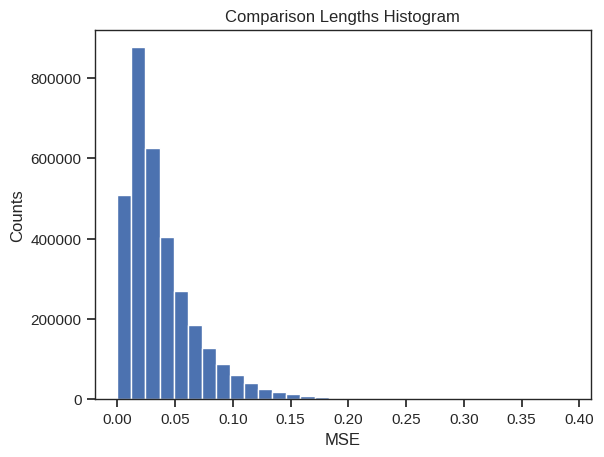

In [ ]:
#Getting all the important info
print("The minimum is", min(mins))
print("The 1st percentile is", np.percentile(mins,1))
print("The 2nd percentile is", np.percentile(mins,2))
print("The 5th percentile is", np.percentile(mins,5))
print("The 10th percentile is", np.percentile(mins,10))
print("The 50th percentile is", np.percentile(mins,50))
#print(xanes.data['formula_pretty'][closesti],xanes.data['formula_pretty'][closestj])
print((0,np.percentile(mins,99)))
plt.hist(mins,32)
plt.title("Comparison Lengths Histogram")
plt.ylabel("Counts")
plt.xlabel("MSE")
#plt.plot(xanes.data['spectrum'][closesti]['x'],xanes.data['spectrum'][closesti]['y'])
#plt.plot(xanes.data['spectrum'][closestj]['x'],xanes.data['spectrum'][closestj]['y'])

In [ ]:
#Calculating Distances/(average Mean squared) in our dataset
length = len(xanes.data)
minimum = 1
mind = np.zeros(int(((length-1)**2 + length - 1)/2))
shift = 0
for i in tqdm(range(len(xanes.data)-1)):
  for j in range(i+1,len(xanes.data)):
    mind[shift] = np.linalg.norm(xanes.data['spectrum'][i]['y']-xanes.data['spectrum'][j]['y'])**2/100
    mind[shift] = 2*mins[shift]/(np.mean(xanes.data['spectrum'][i]['y'])**2+np.mean(xanes.data['spectrum'][j]['y'])**2)
    shift += 1

100%|██████████| 2556/2556 [03:59<00:00, 10.69it/s] 


The minimum is 2.1984166421052352e-08
The 1st percentile is 0.004170452725416003
The 2nd percentile is 0.005477900907016291
The 5th percentile is 0.007929264211458835
The 10th percentile is 0.010805977353922021
The 50th percentile is 0.03248648859950087
(0, np.float64(0.1741799813510057))


Text(0.5, 0, 'MSE')

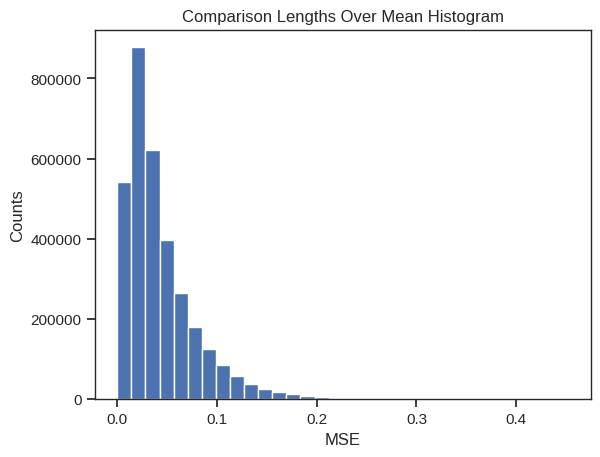

In [ ]:
#Getting more important info about percentile error
print("The minimum is", min(mind))
print("The 1st percentile is", np.percentile(mind,1))
print("The 2nd percentile is", np.percentile(mind,2))
print("The 5th percentile is", np.percentile(mind,5))
print("The 10th percentile is", np.percentile(mind,10))
print("The 50th percentile is", np.percentile(mind,50))
#print(xanes.data['formula_pretty'][closesti],xanes.data['formula_pretty'][closestj])
print((0,np.percentile(mind,99)))
plt.hist(mind,32)
plt.title("Comparison Lengths Over Mean Histogram")
plt.ylabel("Counts")
plt.xlabel("MSE")
#plt.plot(xanes.data['spectrum'][closesti]['x'],xanes.data['spectrum'][closesti]['y'])
#plt.plot(xanes.data['spectrum'][closestj]['x'],xanes.data['spectrum'][closestj]['y'])

In [ ]:
plt.hist(loss,50,(0,np.percentile(loss,99)))
plt.title('Mean Spectrum MSE Histogram for Cu')
plt.ylabel('Count')
plt.xlabel('MSE')

NameError: name 'loss' is not defined

In [ ]:
#Insert the code that will seperate the x's and y's for the alternative model
#Creating a constant test set with random train and val sets
test_size = .2
np.random.seed(42)
num_list = list(np.linspace(0,len(xanes.data)-1,len(xanes.data)))
np.random.shuffle(num_list)

chunk = 4
print("Your chunk number is", chunk)

test_index = num_list[0:int(len(xanes.data)*test_size)]
val_train_index = num_list[int(len(xanes.data)*test_size):]
val_index = val_train_index[int(len(val_train_index)*test_size*(chunk-1)):int(len(val_train_index)*test_size*chunk)]
train_index = val_train_index[:int(len(val_train_index)*test_size*(chunk-1))] + val_train_index[int(len(val_train_index)*test_size*chunk):]

#train_index = []
#for i in range(1,int(1/test_size)+1):
  #if i!=chunk:
    #train_index += val_train_index[int(len(val_train_index)*test_size*(i-1)):int(len(val_train_index)*test_size*i)]

print("The training size is", len(train_index))
print("The validation size is", len(val_index))
print("The test size is", len(test_index))

#process.idx_train = train_index
#process.idx_valid = val_index
#process.idx_test = test_index

Your chunk number is 4
The training size is 882
The validation size is 220
The test size is 275


In [ ]:
#defining the elements
elements = ('H','He','Li','Be','B','C','N','O','F','Ne','Na','Mg','Al','Si','P','S','Cl','Ar','K','Ca','Sc','Ti',
              'V','Cr','Mn','Fe','Co','Ni','Cu','Zn','Ga','Ge','As','Se','Br','Kr','Rb','Sr','Y','Zr','Nb','Mo','Tc','Ru',
              'Rh','Pd','Ag','Cd','In','Sn','Sb','Te','I','Xe','Cs','Ba','La','Ce','Pr','Nd','Pm','Sm','Eu','Gd','Tb',
              'Dy','Ho','Er','Tm','Yb','Lu','Hf','Ta','W','Re','Os','Ir','Pt','Au','Hg','Tl','Pb','Bi','Po','At','Rn',
              'Fr','Ra','Ac','Th','Pa','U','Np','Pu','Am','Cm','Bk','Cf','Es','Fm')


In [ ]:
#Finding the compound with the most elements
max_count = 0
for i in xanes.data.index:
  if len(xanes.data['structure'][i]) > max_count:
    max_count = len(xanes.data['structure'][i])
print(max_count)

248


In [ ]:
#Comparing the average and median MSE as a function of element count
elements = ('H','He','Li','Be','B','C','N','O','F','Ne','Na','Mg','Al','Si','P','S','Cl','Ar','K','Ca','Sc','Ti',
              'V','Cr','Mn','Fe','Co','Ni','Cu','Zn','Ga','Ge','As','Se','Br','Kr','Rb','Sr','Y','Zr','Nb','Mo','Tc','Ru',
              'Rh','Pd','Ag','Cd','In','Sn','Sb','Te','I','Xe','Cs','Ba','La','Ce','Pr','Nd','Pm','Sm','Eu','Gd','Tb',
              'Dy','Ho','Er','Tm','Yb','Lu','Hf','Ta','W','Re','Os','Ir','Pt','Au','Hg','Tl','Pb','Bi','Po','At','Rn',
              'Fr','Ra','Ac','Th','Pa','U','Np','Pu','Am','Cm','Bk','Cf','Es','Fm')
afters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789()'
count = np.zeros(100)
elemental = np.arange(100)
elemental_MSE = np.zeros(100)
shift = -1
for e in tqdm(elements):
  shift += 1
  if len(e) == 2:
    for i in train_index:
      if e in xanes.data['formula_pretty'][i]:
        count[shift] += 1
  else:
    for i in train_index:
      for a in afters:
        if e + a in xanes.data['formula_pretty'][i] or e == xanes.data['formula_pretty'][i][len(xanes.data['formula_pretty'][i])-1]:
          count[shift] += 1
          break
print(count)

  4%|▍         | 4/100 [00:04<01:38,  1.03s/it]


KeyboardInterrupt: 

Average MSE of 0.03341671926182744
Median MSE of 0.02772117969670089
2814 examples


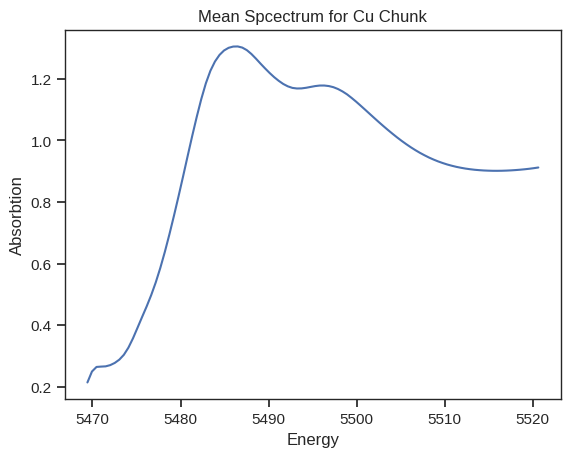

In [ ]:
#Calculating the mean spectrum and the mean and median error from it
means = np.zeros(len(xanes.data['spectrum'][i]['y']))
for i in train_index:
  means += xanes.data['spectrum'][i]['y']
means = means/len(train_index)
plt.plot(x_new,means)
plt.title("Mean Spcectrum for Cu Chunk")
plt.ylabel("Absorbtion")
plt.xlabel("Energy")
loss = np.zeros(len(val_index))
shifter = 0
for i in val_index:
  loss[shifter] += np.mean((xanes.data['spectrum'][i]['y']-means)**2)
  shifter += 1
print("Average MSE of", np.mean(loss))
print("Median MSE of", np.median(loss))
print(len(xanes.data), "examples")


In [ ]:
#Creating the inputs for our alternative model
x_train = np.zeros((len(train_index),100))
y_train = np.zeros((len(train_index),100))
shifter = 0
for i in train_index:
    x_train[shifter] = formula_to_vector(xanes.data['formula_pretty'][i])
    y_train[shifter] = xanes.data['spectrum'][i]['y']
    shifter += 1
shifter = 0
x_val = np.zeros((len(val_index),100))
y_val = np.zeros((len(val_index),100))
for i in val_index:
  x_val[shifter] = formula_to_vector(xanes.data['formula_pretty'][i])
  y_val[shifter] = xanes.data['spectrum'][i]['y']
  shifter += 1

print(len(x_val),len(x_train))

220 882


In [ ]:
#Creating the alternative model
inputs = keras.Input(shape=(100,), name="formula")
x = layers.Dense(100, activation="relu", name="dense_1")(inputs)
x = layers.Dropout(.01)(x)
x = layers.Dense(300, activation="relu", name="dense_2")(x)
x = layers.Dropout(.01)(x)
x = layers.Dense(300, activation="relu", name="dense_3")(x)
outputs = layers.Dense(100, activation="relu", name="Sprectrum")(x)

mymodel = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
#Fitting the model to the data
mymodel.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.MeanSquaredError(),
    metrics=['accuracy'],
)
history = mymodel.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=150,
    validation_data=(x_val, y_val),
)

Epoch 1/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - accuracy: 0.0195 - loss: 0.6705 - val_accuracy: 0.0955 - val_loss: 0.4495
Epoch 2/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.0703 - loss: 0.3939 - val_accuracy: 0.0045 - val_loss: 0.3529
Epoch 3/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0393 - loss: 0.3189 - val_accuracy: 0.0273 - val_loss: 0.2833
Epoch 4/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0527 - loss: 0.2271 - val_accuracy: 0.0818 - val_loss: 0.2220
Epoch 5/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0508 - loss: 0.1539 - val_accuracy: 0.0636 - val_loss: 0.1667
Epoch 6/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0580 - loss: 0.1211 - val_accuracy: 0.0591 - val_loss: 0.1517
Epoch 7/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0797 - loss: 0.0986 - val_accuracy: 0.0773 - val_loss: 0.1141
Epoch 8/150
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0806 - loss: 0.0883 - val_accuracy: 0.

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


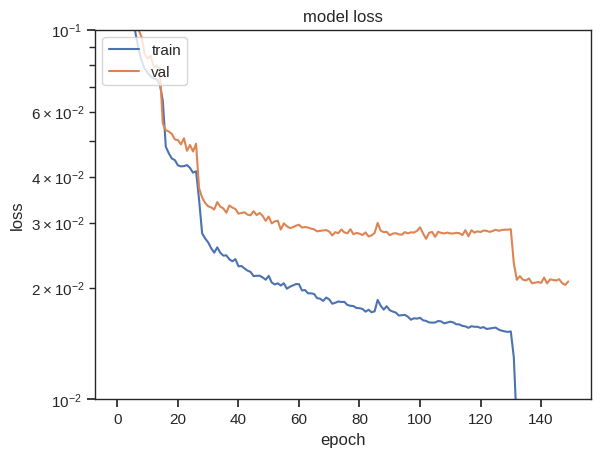

In [ ]:
#Looking at the training history
# list all data in history
print(history.history.keys())
plt.plot(history.history['loss'],)
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'val'], loc='upper left')
plt.ylim((0.01,.1))
plt.show()

In [ ]:
#Getting the important alternative model data
print(min(history.history['val_loss']))

0.020385203883051872


In [ ]:
mymodel.save(element+'_formulaic_model.keras')

In [ ]:
#Loading a specific model
#mymodel = keras.models.load_model('data/Cu_formulaic_model.keras')


In [ ]:
mymodel.predict(np.ones((1,100)))[0] - 10

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


array([ -9.392693 ,  -9.237572 ,  -9.355434 ,  -9.322788 ,  -8.827156 ,
        -9.123827 ,  -8.993301 , -10.       ,  -9.002581 ,  -9.027228 ,
        -8.817717 ,  -8.743331 ,  -8.747006 ,  -8.696967 ,  -8.523262 ,
        -8.319518 ,  -8.572268 ,  -8.393707 ,  -8.459994 ,  -8.567499 ,
        -8.65502  ,  -8.398258 ,  -8.65029  ,  -8.732517 ,  -8.709556 ,
        -8.786558 ,  -8.845554 ,  -8.754939 ,  -9.082119 ,  -9.018617 ,
        -9.277389 ,  -9.019459 ,  -9.249205 ,  -9.238329 ,  -9.099813 ,
        -9.300906 ,  -9.54131  ,  -9.468523 ,  -9.272052 ,  -9.061006 ,
        -9.208074 ,  -9.142913 ,  -9.035967 ,  -8.837978 ,  -9.057714 ,
        -8.897202 ,  -8.80682  ,  -9.006233 ,  -9.127323 ,  -9.12083  ,
        -8.990035 ,  -8.932933 ,  -9.075368 ,  -9.12476  ,  -9.124053 ,
        -9.055832 ,  -9.142815 ,  -9.08933  ,  -9.222134 ,  -8.967513 ,
        -9.039159 ,  -9.223411 ,  -9.114049 ,  -8.942362 ,  -9.163092 ,
        -8.886122 ,  -8.949357 ,  -8.929288 ,  -9.062557 ,  -8.8

In [ ]:
#Getting the MSE of the test set
test_MSE = np.zeros(len(test_index))
shifter = 0
for i in test_index:
  test_input = np.ones((1,100))
  test_input[0] = formula_to_vector(xanes.data['formula_pretty'][i])
  test_MSE[shifter] = np.mean((mymodel.predict(test_input)[0] - xanes.data['spectrum'][i]['y'])**2)
  shifter += 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━

In [ ]:
print(element)
print(np.mean(test_MSE),np.median(test_MSE))

Cr
0.016512778284910566 0.008725434171048978


In [ ]:
test_MAE = np.zeros(len(test_index))
shifter = 0
for i in test_index:
  test_input = np.ones((1,100))
  test_input[0] = formula_to_vector(xanes.data['formula_pretty'][i])
  test_MAE[shifter] = np.mean(abs(mymodel.predict(test_input)[0] - xanes.data['spectrum'][i]['y']))
  shifter += 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━

In [ ]:
print(element)
print(np.mean(test_MAE),np.median(test_MAE))

Cr
0.08045875906530113 0.06707625214300102


In [ ]:
#Getting the elemental count of the training set
elements = ('H','He','Li','Be','B','C','N','O','F','Ne','Na','Mg','Al','Si','P','S','Cl','Ar','K','Ca','Sc','Ti',
              'V','Cr','Mn','Fe','Co','Ni','Cu','Zn','Ga','Ge','As','Se','Br','Kr','Rb','Sr','Y','Zr','Nb','Mo','Tc','Ru',
              'Rh','Pd','Ag','Cd','In','Sn','Sb','Te','I','Xe','Cs','Ba','La','Ce','Pr','Nd','Pm','Sm','Eu','Gd','Tb',
              'Dy','Ho','Er','Tm','Yb','Lu','Hf','Ta','W','Re','Os','Ir','Pt','Au','Hg','Tl','Pb','Bi','Po','At','Rn',
              'Fr','Ra','Ac','Th','Pa','U','Np','Pu','Am','Cm','Bk','Cf','Es','Fm')
afters = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789()'
count = np.zeros(100)
shift = -1
for e in tqdm(elements):
  shift += 1
  if len(e) == 2:
    for i in train_index:
      if e in xanes.data['formula_pretty'][i]:
        count[shift] += 1
  else:
    for i in train_index:
      for a in afters:
        if e + a in xanes.data['formula_pretty'][i] or e == xanes.data['formula_pretty'][i][len(xanes.data['formula_pretty'][i])-1]:
          count[shift] += 1
          break
print(count)


100%|██████████| 100/100 [00:15<00:00,  6.60it/s]

[  57.    0.  159.    0.   25.   47.   46.  898.   78.    0.   53.   74.
   76.   76.  179.  224.   68.    0.   58.   97.   11.   36.   54.   30.
   49.   52.   35.   23. 1637.   64.   23.   71.   69.  142.   27.    0.
   49.   93.   69.   18.   20.   29.    0.    0.    8.    8.   13.   10.
   35.   62.   62.   49.   20.    0.   33.  133.   33.   24.   18.   34.
    0.   31.   16.   21.   19.   28.   34.   21.   16.   16.   10.   12.
   26.   35.    0.    0.    9.   13.   10.   18.   35.   35.   55.    0.
    0.    0.    0.    0.    0.    8.    0.   18.    0.    0.    0.    0.
    0.    0.    0.    0.]


In [ ]:
#Getting the average MSE for each element
elemental_MSE = np.zeros(100)
shift = -1
inputy = np.ones((1,100))
for e in tqdm(elements):
  shift += 1
  if len(e) == 2:
    for u, i in enumerate(test_index):
      if e in xanes.data['formula_pretty'][i]:
        inputy[0] = formula_to_vector(xanes.data['formula_pretty'][i])
        elemental_MSE[shift] += test_MSE[u]/count[shift]
  else:
    for u, i in enumerate(test_index):
      for a in afters:
        if e + a in xanes.data['formula_pretty'][i] or e == xanes.data['formula_pretty'][i][len(xanes.data['formula_pretty'][i])-1]:
          inputy[0] = formula_to_vector(xanes.data['formula_pretty'][i])
          elemental_MSE[shift] += test_MSE[u]/count[shift]
          break
print(elemental_MSE)


100%|██████████| 100/100 [00:05<00:00, 18.04it/s]

[0.00488381 0.         0.00337823 0.         0.00287925 0.00305383
 0.00466121 0.00447247 0.00899442 0.         0.00403041 0.00644495
 0.0052596  0.00314135 0.00211388 0.00102631 0.00439124 0.
 0.00639778 0.00345448 0.00312939 0.0041468  0.00424624 0.00587029
 0.00559031 0.00228128 0.00173647 0.00557935 0.00371868 0.00364602
 0.00066957 0.00214529 0.00464772 0.00132856 0.00421544 0.
 0.00108791 0.00358578 0.00324921 0.00131612 0.00432844 0.00202057
 0.         0.         0.00870573 0.00082192 0.02300626 0.00581921
 0.00806295 0.00245026 0.00117813 0.00276343 0.00526208 0.
 0.00187747 0.00369066 0.0028981  0.00066953 0.00141907 0.00152307
 0.         0.00138215 0.0032342  0.00095086 0.00024516 0.0012147
 0.00171362 0.00163495 0.00274656 0.01587387 0.00918778 0.00064329
 0.00603346 0.00537088 0.         0.         0.00570443 0.00057267
 0.00275817 0.00143756 0.00468794 0.00844778 0.00085299 0.
 0.         0.         0.         0.         0.         0.00039984
 0.         0.00377589 0.   

In [ ]:
#zeroing the element we are on and plotting the correlation
for i,e in enumerate(elements):
  if e == element:
    elemental_MSE[i] = 0
    count[i] = 0
    print(e)
shift = 0
for i in range(100):
  if count[shift] == 0:
    count = np.delete(count,shift)
    elemental_MSE = np.delete(elemental_MSE,shift)
  else:
    shift += 1

Cu


Text(0.5, 0, 'log(Training Examples)')

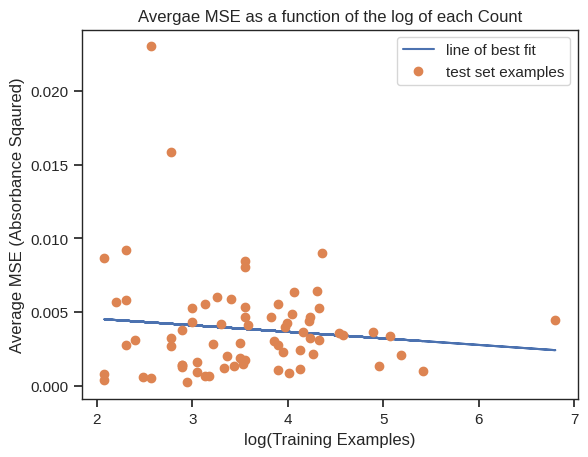

In [ ]:
coeffs = np.polyfit(np.log(count),elemental_MSE,1)
plt.plot(np.log(count),coeffs[1] + coeffs[0]*np.log(count), label="line of best fit")
plt.plot(np.log(count),elemental_MSE, 'o', label="test set examples")
plt.title("Avergae MSE as a function of the log of each Count")
plt.ylabel("Average MSE (Absorbance Sqaured)")
plt.legend()
plt.xlabel("log(Training Examples)")

In [ ]:
#Getting the lin of best fit
np.polyfit(np.log(count),elemental_MSE,1)

array([-0.00044361,  0.00544817])

[0.23044755 0.31776188 0.38642581 0.40873005 0.400685   0.38451922
 0.37316454 0.37685164 0.38907541 0.40014482 0.40919012 0.41959302
 0.43491418 0.45705624 0.49150836 0.54188617 0.60574069 0.67415579
 0.73100257 0.75980413 0.75764992 0.74080782 0.73155388 0.73794539
 0.75287663 0.76889334 0.78893942 0.82141881 0.87046904 0.9327359
 1.00055927 1.06849487 1.13770964 1.19143267 1.21683221 1.21124662
 1.18792259 1.17503792 1.16904862 1.16737849 1.16421368 1.15540212
 1.14191185 1.12350617 1.09829474 1.07375486 1.05063563 1.03788836
 1.03225362 1.03235781 1.03900779 1.04541232 1.05158472 1.05811492
 1.06643174 1.07783775 1.09068796 1.10368652 1.11435683 1.12298978
 1.12926579 1.13221442 1.13393685 1.13211317 1.12939702 1.12503231
 1.11945514 1.11307242 1.10598594 1.09874745 1.09133691 1.08399833
 1.07693548 1.07010008 1.06366538 1.0575155  1.05165725 1.0459165
 1.04025375 1.0344217  1.02851242 1.02228577 1.01595187 1.00949899
 1.00301351 0.99688912 0.99085644 0.98564212 0.980647   0.976604

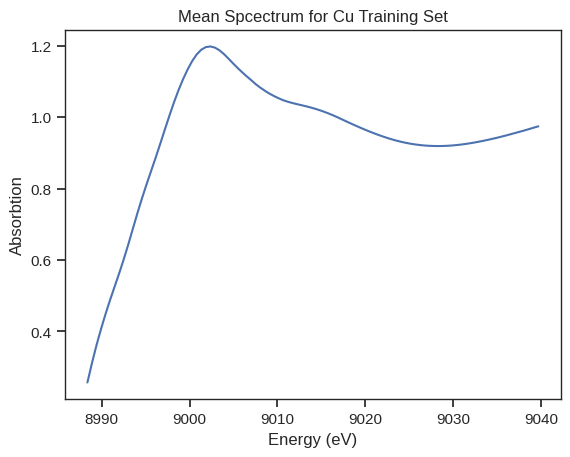

In [ ]:
#Calculating the mean spectrum and the mean and median error from it
means = np.zeros(len(xanes.data['spectrum'][i]['y']))
for i in train_index:
  means += xanes.data['spectrum'][i]['y']
means = means/len(train_index)
plt.plot(x_new,means)
plt.title("Mean Spcectrum for Cu Training Set")
plt.ylabel("Absorbtion")
plt.xlabel("Energy (eV)")
loss = np.zeros(len(test_index))
print(xanes.data['spectrum'][409]['y'])
shifter = 0
for i in test_index:
  loss[shifter] += np.mean((xanes.data['spectrum'][i]['y']-means)**2)
  shifter += 1
print("Average MSE of", np.mean(loss))
print("Median MSE of", np.median(loss))
print(len(xanes.data), "examples")

0.011912874073735995 0.0054598483637801785


<ipython-input-137-c57ce856178d>:1: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.hist(test_MSE,25,(0,np.percentile(test_MSE,95)))


Text(0.5, 0, 'MSE')

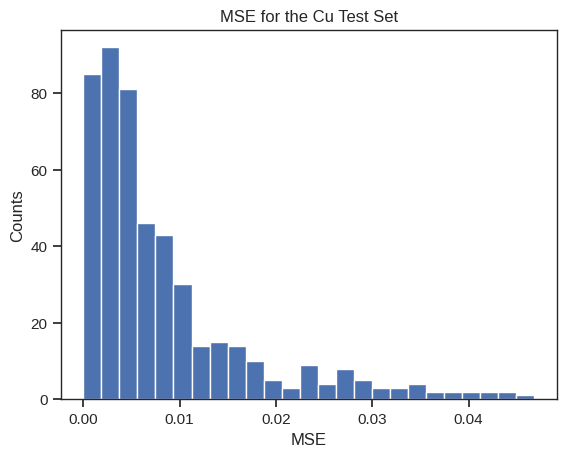

In [ ]:
plt.hist(test_MSE,25,(0,np.percentile(test_MSE,95)))
print(np.mean(test_MSE),np.median(test_MSE))
plt.title("MSE for the Cu Test Set")
plt.ylabel("Counts")
plt.xlabel("MSE")

0.06813383115007313 0.054377471418674765


<ipython-input-153-1fbee546a824>:1: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.hist(test_MAE,25,(0,np.percentile(test_MAE,95)))


Text(0.5, 0, 'MAE')

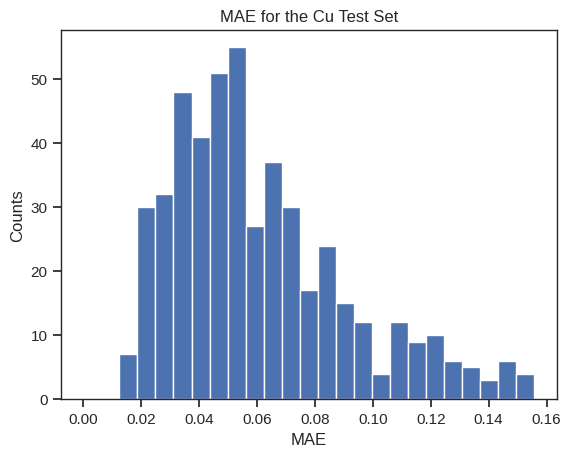

In [ ]:
plt.hist(test_MAE,25,(0,np.percentile(test_MAE,95)))
print(np.mean(test_MAE),np.median(test_MAE))
plt.title("MAE for the Cu Test Set")
plt.ylabel("Counts")
plt.xlabel("MAE")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
0.003937741516864446
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
0.001525193360661682
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
0.0009091764953605578
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
0.0014414084130843438
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
0.06825072408449649
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
0.005109386240372145
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
0.006278318146436042
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
0.004674114385766572
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
0.002377013400027231
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
0.0021070857329288538
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
0.005695235494762371
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
0.005011911239499558
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
0.007259597950801312
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
0.0029839223854385834
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
0.004327831614431002
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
0.039945947907404376
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
0.0028527552010

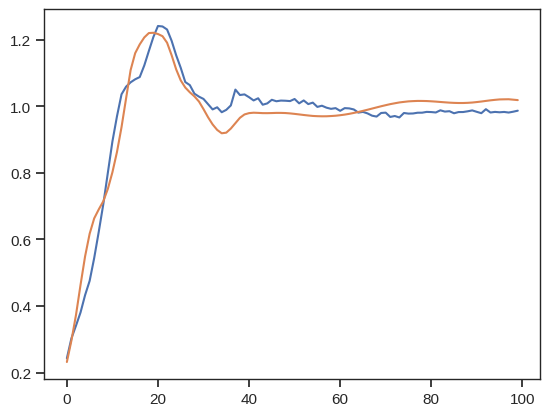

In [ ]:
for i in range(20):
  placer = int(test_index[i])
  test_input[0] = formula_to_vector(xanes.data['formula_pretty'][placer])
  print(np.mean((mymodel.predict(test_input)[0] - xanes.data['spectrum'][placer]['y'])**2))
plt.plot((mymodel.predict(test_input)[0]))
plt.plot(xanes.data['spectrum'][placer]['y'])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
0.005109386240372145
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


Text(0.5, 0, 'Energy (eV)')

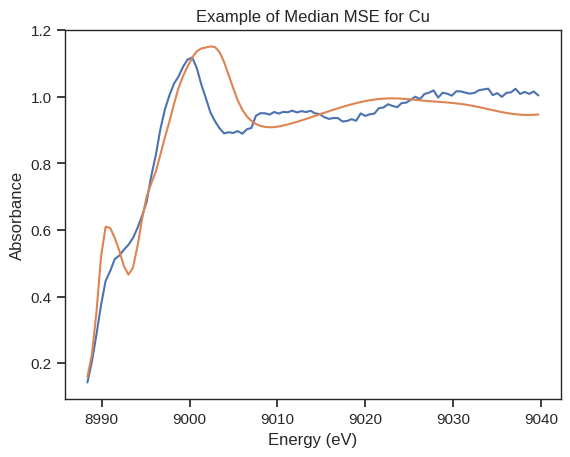

In [ ]:
placer = int(test_index[5])
test_input[0] = formula_to_vector(xanes.data['formula_pretty'][placer])
print(np.mean((mymodel.predict(test_input)[0] - xanes.data['spectrum'][placer]['y'])**2))
plt.plot(x_new,(mymodel.predict(test_input)[0]))
plt.plot(x_new,xanes.data['spectrum'][placer]['y'])
plt.title("Example of Median MSE for Cu")
plt.ylabel("Absorbance")
plt.xlabel("Energy (eV)")


In [ ]:
#Calculating minimum distance in our dataset
length = len(test_index)
mints = np.zeros(int(((length-1)**2 + length - 1)/2))
shift1 = 0
shift2 = 0
for i in tqdm(test_index):
  for j in test_index[shift1+1:]:
    mints[shift2] = np.mean((xanes.data['spectrum'][int(i)]['y']-xanes.data['spectrum'][int(j)]['y'])**2)
    shift2 += 1
  shift1 += 1
print(shift)

100%|██████████| 511/511 [00:03<00:00, 158.70it/s]

511


The minimum is 9.898654808270863e-06
The 1st percentile is 0.0038575172886855602
The 2nd percentile is 0.005079632832818556
The 5th percentile is 0.007442889619150139
The 10th percentile is 0.010172212487718917
The 50th percentile is 0.02948740726701999
(0, np.float64(0.07911019514064596))
0.2948802325558881


<ipython-input-138-9fb927403e8c>:10: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.hist(mints,32,(0,np.percentile(mints,95)))


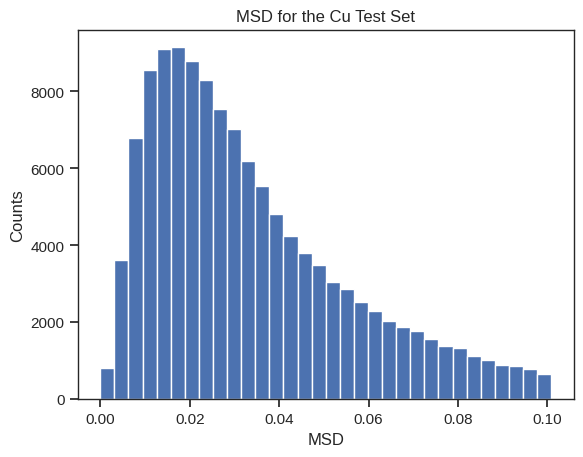

In [ ]:
#Getting more important info
print("The minimum is", min(mints))
print("The 1st percentile is", np.percentile(mints,1))
print("The 2nd percentile is", np.percentile(mints,2))
print("The 5th percentile is", np.percentile(mints,5))
print("The 10th percentile is", np.percentile(mints,10))
print("The 50th percentile is", np.percentile(mints,50))
#print(xanes.data['formula_pretty'][closesti],xanes.data['formula_pretty'][closestj])
print((0,np.percentile(mints,90)))
plt.hist(mints,32,(0,np.percentile(mints,95)))
plt.title("MSD for the Cu Test Set")
plt.ylabel("Counts")
plt.xlabel("MSD")
#plt.plot(xanes.data['spe
print(max(mints))

In [ ]:
#Evaluating the alternative model
alt_test_error = np.zeros((1,len(test_index)))
inputer = np.zeros((1,100))
for i in tqdm(test_index):
  inputer[0] = formula_to_vector(xanes.data['formula_pretty'][i])
  y_temp = mymodel.predict(inputer)[0]
  mean_dif += np.mean(y_temp-xanes.data['spectrum'][i]['y'])**2

mean_dif = mean_dif/len(test_index)

  0%|          | 0/511 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  0%|          | 0/511 [00:00<?, ?it/s]


NameError: name 'mean_dif' is not defined

100%|██████████| 2211/2211 [00:00<00:00, 3846.98it/s]


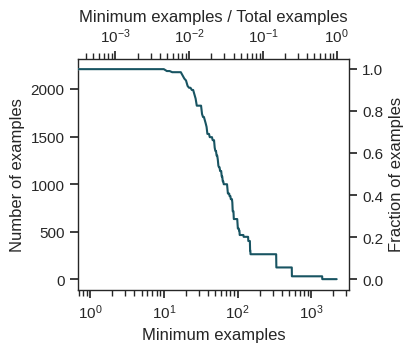

In [ ]:
# Enforce a minimum number of examples of each species
species_min = 0

xanes.get_species_counts()
fig = xanes.plot_species_counts(species_min)
#xanes.set_species_counts(species_min)
#xanes.get_species_counts()
#xanes.savefig('images/species_counts.svg', bbox_inches='tight')

Average lattice parameter (a/b/c): 6.312539045933766 / 7.054354399156004 / 8.772638242841898


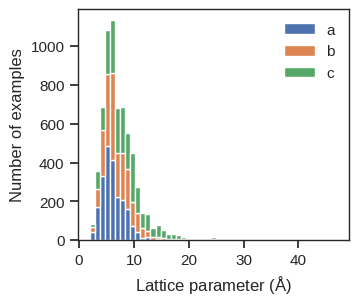

In [ ]:
# Lattice parameter statistics
xanes.get_lattice_parameters()
fig = xanes.plot_lattice_parameters(n_bins=50)
#fig.savefig('images/lattice_parameters.svg', bbox_inches='tight')

## Format input features

In [ ]:
# Get species
species = sorted(list(set(xanes.data['species'].sum())))
n_species = list(np.unique(xanes.data['species'].sum(), return_counts=True)[1])
Z_max = max([Atom(k).number for k in species])
print(Z_max)

92


In [ ]:
# One-hot encoding atom type and mass
type_encoding = {}
mass_specie = []

for Z in tqdm(range(1, Z_max + 1), bar_format=bar_format):
    specie = Atom(Z)
    type_encoding[specie.symbol] = Z - 1
    mass_specie.append(atomic_masses[Z])

type_onehot = torch.eye(len(type_encoding))
mass_onehot = torch.diag(torch.tensor(mass_specie))

100%|██████████| 92/92 [00:00<00:00, 145778.61it/s]


In [ ]:
# Process data into input descriptors
process = Process(species, Z_max, type_encoding, type_onehot, mass_onehot, default_dtype)

r_max = 3.5     # cutoff radius
tqdm.pandas(desc='Building data', bar_format=bar_format)
xanes.data['input'] = xanes.data.progress_apply(lambda x: process.build_data(x, r_max), axis=1)

Building data: 100%|██████████| 2211/2211 [00:36<00:00, 59.84it/s]


## Format training, validation, and test sets

In [ ]:
# Train/valid/test split
#test_size = 0.2
#fig = process.train_valid_test_split(xanes.data, valid_size=test_size, test_size=test_size, plot=True)
#fig.savefig('images/train_valid_test_split.svg', bbox_inches='tight')

In [ ]:
#The better organizer of data
process.idx_train = train_index
process.idx_valid = val_index
process.idx_test = test_index

Average number of neighbors (train/valid/test): 15.034588483280636 / 14.964407274141788 / 15.331061192873742


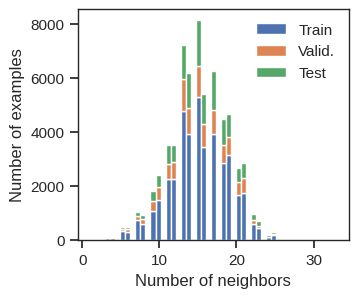

In [ ]:
# Calculate average number of neighbors
process.get_neighbors(xanes.data)
fig = process.plot_neighbors(n_bins=50)
print('Average number of neighbors (train/valid/test):', process.n_train.mean(), '/',
                                                         process.n_valid.mean(), '/',
                                                         process.n_test.mean())
#fig.savefig('images/num_neighbors.svg', bbox_inches='tight')

In [ ]:
# Format dataloaders
#You can replace this
batch_size = 32
dataloader_train = tg.loader.DataLoader(xanes.data.iloc[process.idx_train]['input'].tolist(), batch_size=batch_size,
                                        shuffle=True)
dataloader_valid = tg.loader.DataLoader(xanes.data.iloc[process.idx_valid]['input'].tolist(), batch_size=batch_size)
dataloader_test = tg.loader.DataLoader(xanes.data.iloc[process.idx_test]['input'].tolist(), batch_size=batch_size)

## Build neural network model

In [ ]:
class E3NN(Network):
    def __init__(self, in_dim, out_dim, emb_dim, num_layers, mul, lmax, max_radius, num_basis, radial_layers,
                 radial_neurons, num_neighbors):
        kwargs = {'reduce_output': False,
                  'irreps_in': str(emb_dim)+"x0e",
                  'irreps_out': str(out_dim)+"x0e",
                  'irreps_node_attr': str(emb_dim)+"x0e",
                  'layers': num_layers,
                  'mul': mul,
                  'lmax': lmax,
                  'max_radius': max_radius,
                  'number_of_basis': num_basis,
                  'radial_layers': radial_layers,
                  'radial_neurons': radial_neurons,
                  'num_neighbors': num_neighbors
                 }
        super().__init__(**kwargs)

        # definitions
        self.cmap = plt.get_cmap('plasma')
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.emb_dim = emb_dim
        self.num_layers = num_layers
        self.mul = mul
        self.lmax = lmax
        self.max_radius = max_radius
        self.num_basis = num_basis
        self.radial_layers = radial_layers
        self.radial_neurons = radial_neurons
        self.num_neighbors = num_neighbors

        self.model_name = 'e3nn-xanes_' + '_'.join(i + str(int(j)) for (i,j) in zip(
            ['emb', 'layers', 'mul', 'lmax', 'rmax', 'nbasis', 'rlayers', 'rneurons'],
            [emb_dim, num_layers, mul, lmax, max_radius, num_basis, radial_layers, radial_neurons]))

        # embedding
        self.emb_x = nn.Sequential(
            nn.Linear(in_dim, emb_dim),
            nn.ReLU()
        )

        self.emb_z = nn.Sequential(
            nn.Linear(in_dim, emb_dim),
            nn.Tanh()
        )


    def forward(self, data):
        data['x'] = self.emb_x(data['x_in'])
        data['z'] = self.emb_z(data['z_in'])
        x = super().forward(data)[0]

        # aggregate
        if 'batch' in data:
            batch = data['batch']
        else:
            batch = data['pos'].new_zeros(data['pos'].shape[0], dtype=torch.long)

        y = torch_scatter.scatter_mean(x, batch, dim=0)
        return y


    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


    def loss(self, y_pred, y_true):
        return torch.mean((y_pred-y_true)**2)


    def checkpoint(self, dataloader, device):
        self.eval()

        loss_cum = 0.
        with torch.no_grad():
            for j, d in enumerate(dataloader):
                d.to(device)
                y_pred = self.forward(d)

                loss = self.loss(y_pred, d.y).cpu()
                loss_cum += loss.detach().item()

        return loss_cum/len(dataloader)


    def fit(self, opt, dataloader_train, dataloader_valid, history, s0, max_iter=10, device="cpu", scheduler=None):
        chkpt = 1

        for step in range(max_iter):
            self.train()

            loss_cum = 0.
            start_time = time.time()

            for j, d in enumerate(dataloader_train):
                d.to(device)
                y_pred = self.forward(d)

                loss = self.loss(y_pred, d.y).cpu()
                loss_cum += loss.detach().item()

                print(f"Iteration {step+1:5d}    batch {j+1:5d} / {len(dataloader_train):5d}   " +
                      f"batch loss = {loss.data:.4e}", end="\r", flush=True)

                opt.zero_grad()
                loss.backward()
                opt.step()

            if scheduler is not None:
                scheduler.step()

            end_time = time.time()
            wall = end_time - start_time

            if (step+1)%chkpt == 0:
                print(f"Iteration {step+1:5d}    batch {j+1:5d} / {len(dataloader_train):5d}   " +
                      f"epoch loss = {loss_cum/len(dataloader_train):.4e}")

                loss_valid = self.checkpoint(dataloader_valid, device)
                loss_train = self.checkpoint(dataloader_train, device)

                history.append({
                    'step': step + s0,
                    'wall': wall,
                    'batch': {
                        'loss': loss.item(),
                    },
                    'valid': {
                        'loss': loss_valid,
                    },
                     'train': {
                         'loss': loss_train,
                     },
                })

                yield {
                    'history': history,
                    'state': self.state_dict(),
                    'optimizer': opt.state_dict(),
                    'scheduler': scheduler.state_dict() if scheduler else None
                }

In [ ]:
args_enn = {'in_dim': Z_max,
            'out_dim': xanes.data.iloc[0]['input'].y.shape[-1],
            'emb_dim': 64,
            'num_layers': 2,
            'mul': 32,
            'lmax': 2,
            'max_radius': r_max,
            'num_basis': 10,
            'radial_layers': 1,
            'radial_neurons': 100,
            'num_neighbors': process.n_train.mean(),
          }

enn = E3NN(**args_enn).to(device)
opt = torch.optim.Adam(enn.parameters(), lr=1e-3)
scheduler = None #torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.99)

model_num = 0
model_path = 'models/' + enn.model_name + '_' + str(model_num) + '.torch'

print(model_path)
#print(enn)
print('Number of parameters:', enn.count_parameters())

models/e3nn-xanes_emb64_layers2_mul32_lmax2_rmax3_nbasis10_rlayers1_rneurons100_0.torch
Number of parameters: 4974136


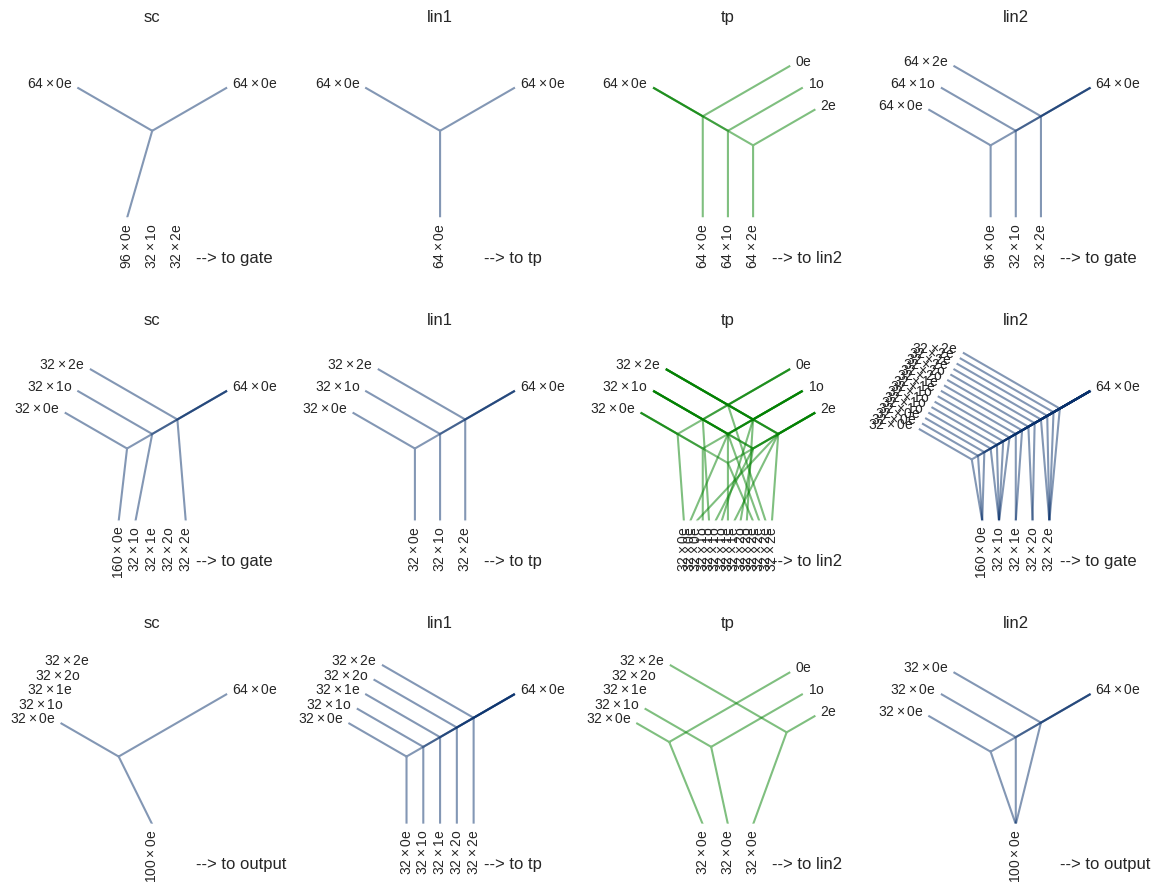

In [ ]:
fig = enn.visualize()

## Train model

In [ ]:
resume = False

if resume:
    saved = torch.load(model_path, map_location=device)
    enn.load_state_dict(saved['state'])
    opt.load_state_dict(saved['optimizer'])
    try:
        scheduler.load_state_dict(saved['scheduler'])
    except:
        scheduler = None
    history = saved['history']
    s0 = history[-1]['step'] + 1

else:
    history = []
    s0 = 0

In [ ]:
  # fit E3NN
  for results in enn.fit(opt, dataloader_train, dataloader_valid, history, s0, max_iter=50, device=device,
                        scheduler=scheduler):
      with open(model_path, 'wb') as f:
          torch.save(results, f)

Iteration     1    batch    45 /    45   epoch loss = 9.5228e-01
Iteration     2    batch    45 /    45   epoch loss = 5.4385e-01
Iteration     3    batch    45 /    45   epoch loss = 1.0632e-01
Iteration     4    batch    45 /    45   epoch loss = 4.6619e-02
Iteration     5    batch    45 /    45   epoch loss = 3.2613e-02
Iteration     6    batch    45 /    45   epoch loss = 2.8084e-02
Iteration     7    batch    45 /    45   epoch loss = 2.4742e-02
Iteration     8    batch    45 /    45   epoch loss = 2.2971e-02
Iteration     9    batch    45 /    45   epoch loss = 2.1036e-02
Iteration    10    batch    45 /    45   epoch loss = 1.9870e-02
Iteration    11    batch    45 /    45   epoch loss = 1.8651e-02
Iteration    12    batch    45 /    45   epoch loss = 1.7669e-02
Iteration    13    batch    45 /    45   epoch loss = 1.7084e-02
Iteration    14    batch    45 /    45   epoch loss = 1.6250e-02
Iteration    15    batch    45 /    45   epoch loss = 1.5638e-02
Iteration    16    batch 

In [ ]:
if not os.path.exists('images/' + enn.model_name + '_' + str(model_num)):
    os.makedirs('images/' + enn.model_name + '_' + str(model_num))

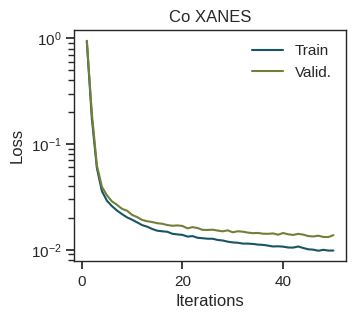

In [ ]:
saved = torch.load(model_path, map_location=device)
history = saved['history']

steps = [d['step'] + 1 for d in history]
loss_train = [d['train']['loss'] for d in history]
loss_valid = [d['valid']['loss'] for d in history]

fig, ax = plt.subplots(figsize=(3.5,3))
ax.plot(steps, loss_train, label='Train', color=process.colors['Train'])
ax.plot(steps, loss_valid, label='Valid.', color=process.colors['Valid.'])

ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
#ax.set_ylim([0,1])
ax.set_title(element+' XANES')
ax.legend(frameon=False)
ax.set_yscale('log')
fig.savefig('images/' + enn.model_name + '_' + str(model_num) + '/loss.svg', bbox_inches='tight')

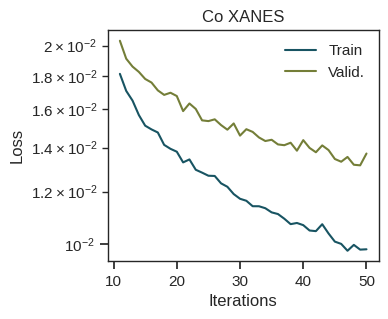

In [ ]:
saved = torch.load(model_path, map_location=device)
history = saved['history']

steps = [d['step'] + 1 for d in history]
loss_train = [d['train']['loss'] for d in history]
loss_valid = [d['valid']['loss'] for d in history]

fig, ax = plt.subplots(figsize=(3.5,3))
ax.plot(steps[10:], loss_train[10:], label='Train', color=process.colors['Train'])
ax.plot(steps[10:], loss_valid[10:], label='Valid.', color=process.colors['Valid.'])

ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
#ax.set_ylim([0,1])
ax.set_title(element + ' XANES')
ax.legend(frameon=False)
ax.set_yscale('log')
fig.savefig('images/' + enn.model_name + '_' + str(model_num) + '/loss.svg', bbox_inches='tight')

## Evaluate model

In [ ]:
#Comparing some
test_y_true = np.zeros((batch_size*len(dataloader_test),100))
test_y_pred = np.zeros((batch_size*len(dataloader_test),100))
current = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with torch.no_grad():
  for j,d in enumerate(dataloader_test):
    inputs = d.to(device)  # Adjust 'input' according to your data keys
    targets = d['y'].to(device)

    test_y_pred[current:current+len(d.y)] = enn(d).cpu().numpy()
    test_y_true[current:current+len(d.y)] = targets.cpu().numpy()
    current += len(d.y)

In [ ]:
#Getting the cosine similarity
print('The Cosine similarity is')
print(np.sum(test_y_pred*test_y_true)/((np.sum(test_y_pred**2))**(1/2)*(np.sum(test_y_true**2))**(1/2)))

The Cosine similarity is
0.9934789163473521


In [ ]:
#Find the average error:
error = np.zeros(len(test_y_pred))
for i in range(len(test_y_pred)):
  error[i] = np.mean((test_y_pred[i]-test_y_true[i])**2)
  #if np.mean((test_y_pred[i]-test_y_true[i])**2) == 7.898989:
    #plt.plot(x_new,test_y_pred[i])
    #plt.plot(x_new,test_y_true[i])
print("Quartile 1 is", np.percentile(error,25))
print("The median is", np.median(error))
print("Quartile 3 is", np.percentile(error,75))
print(("The mean is"), np.mean(error))

Quartile 1 is 0.0034565634144397917
The median is 0.005985250018148069
Quartile 3 is 0.011130847441817594
The mean is 0.01238621933932502


In [ ]:
#Find the average error:
error = np.zeros(len(test_y_pred))
for i in range(len(test_y_pred)):
  error[i] = np.mean(abs(test_y_pred[i]-test_y_true[i]))
  #if np.mean((test_y_pred[i]-test_y_true[i])**2) == 7.898989:
    #plt.plot(x_new,test_y_pred[i])
    #plt.plot(x_new,test_y_true[i])
print("Quartile 1 is", np.percentile(error,25))
print("The median is", np.median(error))
print("Quartile 3 is", np.percentile(error,75))
print(("The mean is"), np.mean(error))

Quartile 1 is 0.04516133361252025
The median is 0.05911495024492525
Quartile 3 is 0.07927573529414517
The mean is 0.0699505251544859


Average MSE of 0.07701868677702639
Median MSE of 0.07317247326529207
2557 examples


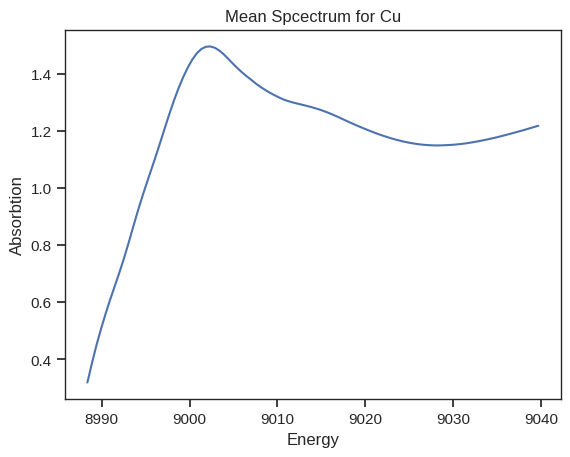

In [ ]:
#Calculating the mean spectrum and the mean and median error from it (From the test and val set)
means = np.zeros(len(xanes.data['spectrum'][i]['y']))
for i in train_index+val_index:
  means += xanes.data['spectrum'][i]['y']
means = means/len(train_index)
plt.plot(x_new,means)
plt.title("Mean Spcectrum for "+element)
plt.ylabel("Absorbtion")
plt.xlabel("Energy")
loss = np.zeros(len(test_index))
shifter = 0
for i in test_index:
  loss[shifter] += np.mean((xanes.data['spectrum'][i]['y']-means)**2)
  shifter += 1
print("Average MSE of", np.mean(loss))
print("Median MSE of", np.median(loss))
print(len(xanes.data), "examples")


Average MAE of 0.25149170810261584
Median MAE of 0.24717004940652576
2557 examples


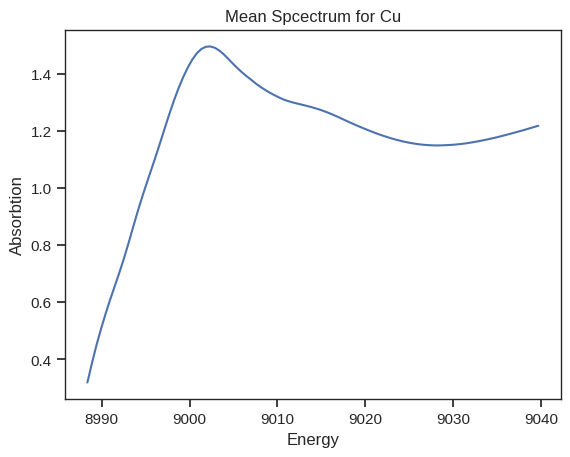

In [ ]:
#Calculating the mean spectrum and the mean and median error from it (Fir the test set)
means = np.zeros(len(xanes.data['spectrum'][i]['y']))
for i in train_index+val_index:
  means += xanes.data['spectrum'][i]['y']
means = means/len(train_index)
plt.plot(x_new,means)
plt.title("Mean Spcectrum for "+element)
plt.ylabel("Absorbtion")
plt.xlabel("Energy")
loss = np.zeros(len(test_index))
shifter = 0
for i in test_index:
  loss[shifter] += np.mean(abs(xanes.data['spectrum'][i]['y']-means))
  shifter += 1
print("Average MAE of", np.mean(loss))
print("Median MAE of", np.median(loss))
print(len(xanes.data), "examples")

MSE = 0.005794624085581237


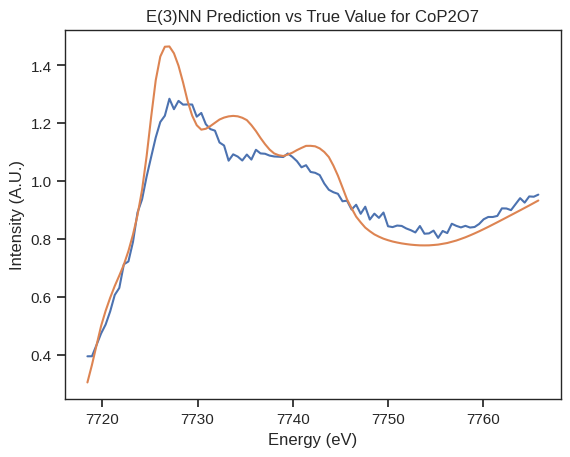

In [ ]:


plt.plot(x_new,test_y_pred[100])
plt.plot(x_new,test_y_true[100])
plt.title("E(3)NN Prediction vs True Value for " + xanes.data['formula_pretty'][int(test_index[100])])
plt.ylabel('Intensity (A.U.)')
plt.xlabel('Energy (eV)')
print("MSE =",np.mean((test_y_pred[100]-test_y_true[100])**2) )
#print(max(error))
#print(min(error[:len(error)-10]))

Average MSE of 0.0699505251544859
Median MSE of 0.05911495024492525


<ipython-input-53-e8a10111f50d>:1: MatplotlibDeprecationWarning: Passing the range parameter of hist() positionally is deprecated since Matplotlib 3.9; the parameter will become keyword-only in 3.11.
  plt.hist(error,25,(0,np.percentile(error,99)))


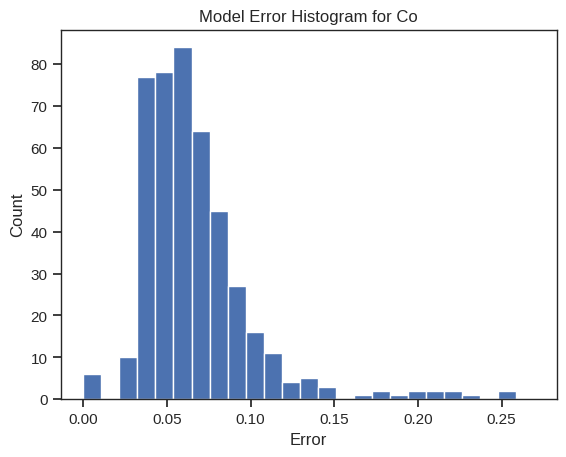

In [ ]:
plt.hist(error,25,(0,np.percentile(error,99)))
plt.title('Model Error Histogram for '+element)
plt.ylabel('Count')
plt.xlabel('Error')
print("Average MSE of", np.mean(error))
print("Median MSE of", np.median(error))

In [ ]:
#Smoothing out the predictions through convolution
#for i in range(len(test_y_pred)):
  temp = np.append(test_y_pred[i][0],test_y_pred[i])
  temp = np.append(temp,test_y_pred[i][len(test_y_pred[i])-1])
  temp = np.convolve(temp,[.25,.5,.25])
  temp = np.delete(temp,len(temp)-1)
  temp = np.delete(temp,len(temp)-1)
  temp = np.delete(temp,0)
  test_y_pred[i] = np.delete(temp,0)

IndentationError: unexpected indent (<ipython-input-49-04b44abb674c>, line 3)